In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_wine

from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, mean_absolute_error, accuracy_score, \
    f1_score, log_loss, classification_report, roc_curve, auc, roc_auc_score, silhouette_samples, silhouette_score

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering

from sklearn.metrics import calinski_harabasz_score

from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from get_metrics import get_metrics_classification

from umap import UMAP

import warnings

warnings.filterwarnings("ignore")

RAND = 10

In [2]:
df = pd.read_csv(
    'C:/Users/vikto/Homeworks (PyMagic)/Финальный проект/Baseline & Tuning/df_labels_EDA.csv'
)

In [3]:
df

name  Принимает_у_себя  Выезд_к_клиенту  \
0                         Emil Mekhriev                 1                1   
1               Ирина Юрьевна Попенкова                 0                0   
2           Александр Юрьевич Иванченко                 0                0   
3             Максим Станиславович Юдин                 1                0   
4             Светлана Андреевна Орлова                 1                1   
...                                 ...               ...              ...   
1992      Наталья Григорьевна Трегубова                 1                1   
1993    Диана Александровна Гапсаламова                 0                1   
1994       Татьяна Владимировна Олийник                 1                1   
1995  Екатерина Александровна Субботина                 1                1   
1996       Дмитрий Анатольевич Микрюков                 0                0   

      Работает_удаленно  Носитель английского  стажировка в США  \
0                     1                     1                 0   
1                     1                     0                 0   
2                     1                     0                 0   
3                     1                     0                 1   
4                     1                     0                 0   
...                 ...                   ...               ...   
1992                  1                     0                 0   
1993                  1                     0                 0   
1994                  1                     0                 0   
1995                  1                     0                 0   
1996                  1                     0                 0   

      стажировка в Англии  переводчик  лингвист  подготовка_к_IELTS  ...  \
0                       0           0         0                   1  ...   
1                       0           0         1                   1  ...   
2                       0           1         0                   1  ...   
3                       0           1         1                   1  ...   
4                       0           0         0                   1  ...   
...                   ...         ...       ...                 ...  ...   
1992                    0           0         1                   0  ...   
1993                    0           0         0                   0  ...   
1994                    0           0         0                   0  ...   
1995                    0           1         1                   0  ...   
1996                    0           1         1                   0  ...   

      более_250_отзывов  менее_50_отзывов  ср_цена_1500-3500  ср_цена_<1500  \
0                     1                 0                  1              0   
1                     0                 0                  1              0   
2                     0                 0                  1              0   
3                     1                 0                  1              0   
4                     0                 0                  0              0   
...                 ...               ...                ...            ...   
1992                  0                 1                  1              0   
1993                  0                 1                  1              0   
1994                  0                 1                  0              1   
1995                  0                 1                  0              1   
1996                  0                 0                  0              1   

      ср_цена_>3500  уровень_знаний_подтверждён  нет_скидок  паспорт_проверен  \
0                 0                           1           1                 1   
1                 0                           1           1                 1   
2                 0                           1           1                 1   
3                 0                           0           0                 1   
4                 1       

In [4]:
df_cleaned = df.drop(columns=['name'])

In [5]:
def calculate_optimal_distance(list_clusters, list_score):
    """
    Поиск наибольшего расстояния для метода локтя
    """
    x1, y1 = list_clusters[0], list_score[0]
    x2, y2 = list_clusters[-1], list_score[-1]
    A, B, C = y1 - y2, x2 - x1, x1 * y2 - x2 * y1

    max_dist = -np.inf
    max_x = -np.inf
    for num, i in enumerate(list_score[1:-1]):
        x_0, y_0 = list_clusters[1:-1][num], list_score[1:-1][num]
        dist = abs(A * x_0 + B * y_0 + C) / np.sqrt(A**2 + B**2)

        if dist > max_dist:
            max_dist = dist
            max_x = x_0
        else:
            continue
    return max_dist, max_x


def elbow_picture(labels_std: list, labels_min: list, labels_max: list,
                  labels_median: list, type_optimal: list, min_size: int,
                  max_size: int):
    """
    Метод локтя

    Функция для вывода графика зависимостей стандартной ошибки, 
    минимального и максимального числа объектов от кол-ва кластеров
    """

    _, opt_cluster = calculate_optimal_distance(range(min_size, max_size + 1),
                                                type_optimal)

    plt.figure(figsize=(8, 6))
    plt.plot(range(min_size, max_size + 1),
             labels_std,
             marker='s',
             color='green',
             label='std')
    plt.plot(range(min_size, max_size + 1),
             labels_min,
             marker='s',
             color='grey',
             linestyle='dashed',
             label='min')
    plt.plot(range(min_size, max_size + 1),
             labels_median,
             marker='o',
             color='skyblue',
             linestyle='dashed',
             label='median')
    plt.plot(range(min_size, max_size + 1),
             labels_max,
             marker='o',
             color='grey',
             linestyle='dashed',
             label='max')
    plt.xlabel('Кластер')
    plt.ylabel('Станд.ошибка / Мин.кластер / Median / Макс.кластер')
    plt.axvline(x=opt_cluster,
                color='black',
                label=f'optimal clust= {opt_cluster}',
                linestyle='dashed')
    plt.legend()
    plt.show()


def silhouette_plot(data: pd.DataFrame,
                    labels: pd.Series,
                    metric='euclidean',
                    ax=None):
    """
    Функция вывода графика силуэтного скора
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(7, 5)

    silhouette_vals = silhouette_samples(data, labels, metric=metric)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(range(y_lower, y_upper),
                cluster_silhouette_vals,
                edgecolor='none',
                height=1)
        ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Получение средней оценки силуэтного скора и построение графика
    avg_score = np.mean(silhouette_vals)
    ax.axvline(avg_score, linestyle='--', linewidth=1, color='red')
    ax.set_xlabel(f'Silhouette  = {round(avg_score,1)}')
    ax.set_ylabel('Метки кластеров')
    ax.set_title('График силуэта для различных кластеров', y=1.02)


def metric_picture(score_list: float,
                   min_size: int,
                   max_size: int,
                   name_metric,
                   optimal: bool = True):
    """
    Функция для вывода графика зависимости метрики от кол-ва кластеров
    """
    plt.figure(figsize=(8, 6))
    if optimal:
        _, opt_cluster = calculate_optimal_distance(range(
            min_size, max_size + 1),
                                                    list_score=score_list)
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.axvline(x=opt_cluster,
                    color='black',
                    label=f'optimal clust= {opt_cluster}',
                    linestyle='dashed')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    else:
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    plt.show()


def check_fullness(data, labels):
    """
    Функция для проверки медианной заполненности кластера
    Для бинаризованных данных
    """
    sums = []
    # Пробегаем по кластерам
    for label in np.unique(labels):
        # Находим медианную заполненность кластера
        cluster_quantile = data[labels == label].sum(axis=0).quantile(.5)
        sums.append(cluster_quantile)
    pd.DataFrame(sums).sort_values(by=[0]).plot(kind="barh", figsize=(8, 6))
    plt.title('Заполненность кластеров')
    plt.ylabel('clusters')
    plt.show()


def plot_size(data: pd.DataFrame, labels: pd.Series):
    """
    Фунция для вывода графика размера кластеров    
    """
    plt.title('Размер кластеров')
    cluster_size = data.assign(
        cluster=labels).groupby('cluster').count().iloc[:, 0]
    cluster_size.sort_values().plot.barh(figsize=(6, 4), color='C0')
    plt.show()


def plot_top_features(data, labels, n_clusters):
    """
    ТОП-признаки для бинаризованных данных
    """
    binary_label = data.assign(cluster=labels)
    size_cluster = binary_label.groupby('cluster').count().iloc[:, 0]
    data_sum = binary_label.groupby('cluster').sum()
    data_sum_norm = data_sum.T / size_cluster

    fig, ax_lst = plt.subplots(n_clusters, 1, figsize=(6, n_clusters * 5))
    plt.subplots_adjust(wspace=0.8, hspace=0.3)
    for i in range(n_clusters):
        ax_lst.reshape(-1)[i].set_title('cluster = ' + str(i))
        data_sum_norm.loc[:, i].sort_values()[-10:].plot.barh(
            ax=ax_lst.reshape(-1)[i], color='C0')
    plt.show()

## UMAP

In [6]:
um = UMAP(n_components=2, random_state=RAND)
clean_df_embedding = um.fit_transform(df_cleaned)

In [7]:
clean_df_embedding

array([[ 3.8643184,  9.120727 ],
       [ 4.7272024, 10.80931  ],
       [ 1.1769353,  9.314732 ],
       ...,
       [ 5.5699053,  7.2593193],
       [ 5.676686 , 12.716689 ],
       [ 1.2010646, 11.557996 ]], dtype=float32)

<AxesSubplot: >

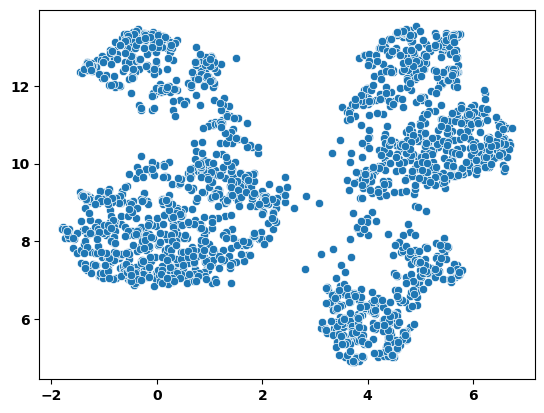

In [8]:
sns.scatterplot(x=clean_df_embedding[:, 0], y=clean_df_embedding[:, 1])

## Функции

In [ ]:
def save_metric(model, scoring, best_score, df):
    #     if scoring not in df.columns:
    #         df[scoring] = pd.Series(dtype=float)
    df.loc[model, scoring] = best_score

In [ ]:
save_metric('kmeans', 'silhouette', silhouette_score(df_cleaned, labels_km),
            metrics)

In [ ]:
# Вариант, где на вход подается не по одной метрике
def save_metric2(model, metrics_scores, df):
    for metric, score in metrics_scores:
        if metric not in df.columns:
            df[metric] = pd.Series(dtype=float)
        df.loc[model, metric] = score

In [ ]:
save_metric2('kmeans',
             [('silhouette', silhouette_score(df_cleaned, labels_km)),
              ('davies-bouldin', davies_bouldin_score(df_cleaned, labels_km))],
             metrics)

In [ ]:
# Вариант, где на вход подается не по одной метрике И метрика считается внутри
# ПРОТЕСТИТЬ для metrics.append(save_metric3())
def save_metric3(model_name, df_cleaned, labels):
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [model_name]
    df_metrics['silhouette'] = silhouette_score(df_cleaned, labels)
    df_metrics['calinski-harabasz'] = calinski_harabasz_score(
        df_cleaned, labels)
    df_metrics['davies-bouldin'] = davies_bouldin_score(df_cleaned, labels)
    return df_metrics

In [ ]:
metrics = save_metric3('kmeans', df_cleaned, labels_km)
# для последующих разов
# metrics = metrics.append(
#     save_metric3('kmeans', df_cleaned, labels_km))
# round(metrics.set_index('model'), 4)

In [ ]:
# ф-я для вывода лучшего результата (работает НО здесь не нужна)
# PS нужны правки - перезаписывает best_score когда не надо
def best_result(scoring, best_param, best_score):
    best_param_old = {}
    best_score_old = 0
    if scoring == "silhouette" or scoring == "calinski-harabasz":
        if best_score_old >= best_score:
            return best_score_old, best_param_old
        if best_score_old < best_score:
            best_param_old = best_param
            best_score_old = best_score
            return best_score_old, best_param_old
    if scoring == "davies-bouldin":
        if best_score_old <= best_score:
            return best_score_old, best_param_old
        if best_score_old > best_score:
            best_param_old = best_param
            best_score_old = best_score
            return best_score_old, best_param_old
        
result = best_result('silhouette', grid_cv.best_params_, grid_cv.best_score_)
print(f'KMeans best result: {result}')

In [ ]:
def top_features_by_categories(data: pd.DataFrame, n_clusters: int):
    """
    ТОП-признаков в каждом кластере
    """
    # рассчитываем кол-во эл-ов в каждом кластере(от общего кол-ва строк)
    # по сути value_count
    size_cluster = data.groupby('target').count().iloc[:, 0]
    # представленность каждого из признаков в кластере
    # проще - кол-во элементов каждого признака в кластере
    data_sum = data.groupby('target').sum()
    #   нормируем на размер кластера
    data_sum_norm = data_sum.T / size_cluster

    fig, ax_lst = plt.subplots(n_clusters, 1, figsize=(6, n_clusters * 5))
    plt.subplots_adjust(wspace=0.8, hspace=0.3)
    for i in range(n_clusters):
        ax_lst.reshape(-1)[i].set_title(f'{i} кластер')
        data_sum_norm.loc[:, i].sort_values()[-15:].plot.barh(
            ax=ax_lst.reshape(-1)[i], color='maroon')
    plt.show()

## K-means

GRIDSEARCH

In [55]:
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200, 300],
    'random_state': [RAND]
}

clf_km = KMeans()
grid_cv = GridSearchCV(clf_km,
                       parameters_grid,
                       verbose=1)

In [56]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Wall time: 8.58 s


GridSearchCV(estimator=KMeans(),
             param_grid={'init': ['k-means++', 'random'],
                         'max_iter': [100, 200, 300], 'n_clusters': [3, 4, 5],
                         'random_state': [10]},
             verbose=1)

In [57]:
grid_cv.best_params_

{'init': 'random', 'max_iter': 100, 'n_clusters': 5, 'random_state': 10}

In [10]:
clf_km = KMeans(n_clusters=5, random_state=RAND, init='random', max_iter=100)
labels_km = clf_km.fit_predict(df_cleaned)

In [11]:
km_final = df_cleaned.assign(target=labels_km)
km_final[:4]

Принимает_у_себя  Выезд_к_клиенту  Работает_удаленно  Носитель английского  \
0                 1                1                  1                     1   
1                 0                0                  1                     0   
2                 0                0                  1                     0   
3                 1                0                  1                     0   

   стажировка в США  стажировка в Англии  переводчик  лингвист  \
0                 0                    0           0         0   
1                 0                    0           0         1   
2                 0                    0           1         0   
3                 1                    0           1         1   

   подготовка_к_IELTS  подготовка_к_IELTS_Academic  ...  менее_50_отзывов  \
0                   1                            1  ...                 0   
1                   1                            0  ...                 0   
2                   1                            0  ...                 0   
3                   1                            1  ...                 0   

   ср_цена_1500-3500  ср_цена_<1500  ср_цена_>3500  \
0                  1              0              0   
1                  1              0              0   
2                  1              0              0   
3                  1              0              0   

   уровень_знаний_подтверждён  нет_скидок  паспорт_проверен  \
0                           1           1                 1   
1                           1           1                 1   
2                           1           1                 1   
3                           0           0                 1   

   доля_плохих_отзывов_10%_и_более  отзывов_5_звезд_больше_95%  target  
0                                0                           0       2  
1                                0                           0       1  
2                                0                           1       0  
3                                0                           1       2  

[4 rows x 53 columns]

In [12]:
km_final['target'].value_counts()

0    490
1    434
4    418
3    344
2    311
Name: target, dtype: int64

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 5')

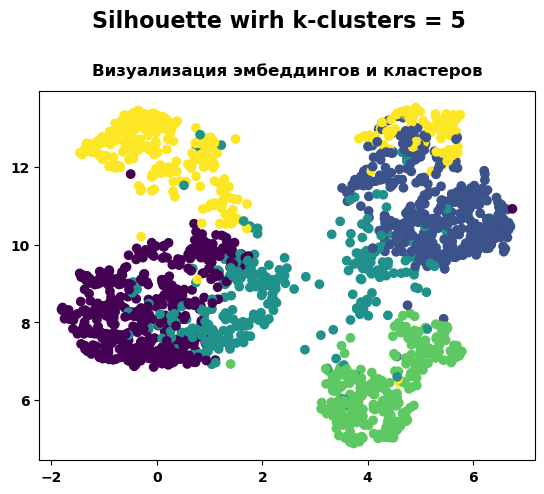

In [13]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_km)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {5}',
             fontsize=16,
             y=1.05)

In [28]:
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'init': ['k-means++', 'random'],
    'max_iter': [50, 100, 200],
    'n_init': [5, 10, 15],
    'algorithm': ["auto", "full", "elkan"],
    'random_state': [RAND]
}

clf_km = KMeans()
grid_cv = GridSearchCV(clf_km, parameters_grid, verbose=1)

In [29]:
%%time
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Wall time: 1min 55s


GridSearchCV(estimator=KMeans(),
             param_grid={'algorithm': ['auto', 'full', 'elkan'],
                         'init': ['k-means++', 'random'],
                         'max_iter': [50, 100, 200], 'n_clusters': [3, 4, 5],
                         'n_init': [5, 10, 15], 'random_state': [10]},
             verbose=1)

In [30]:
grid_cv.best_params_

{'algorithm': 'auto',
 'init': 'random',
 'max_iter': 50,
 'n_clusters': 5,
 'n_init': 10,
 'random_state': 10}

In [33]:
clf_km = KMeans(n_clusters=5, random_state=RAND, init='random', max_iter=50)
labels_km = clf_km.fit_predict(df_cleaned)

In [34]:
km_final = df_cleaned.assign(target=labels_km)
km_final['target'].value_counts()

0    490
1    434
4    418
3    344
2    311
Name: target, dtype: int64

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 5')

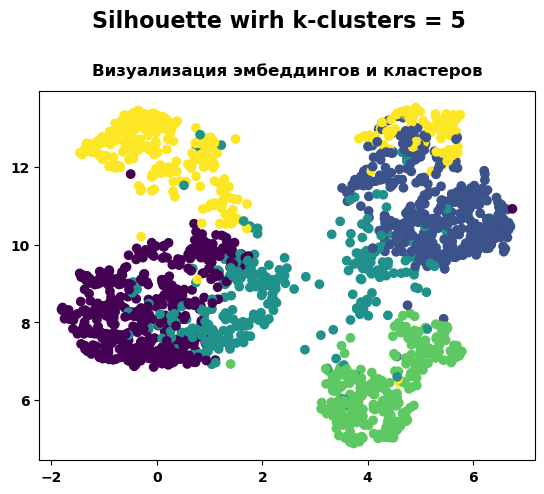

In [35]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_km)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {5}',
             fontsize=16,
             y=1.05)

## Spectral_clusterization

GRIDSEARCH

In [158]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, make_scorer

In [111]:
#подбираем gamma
parameters_grid = {
    'n_clusters': [3, 4],
    'affinity': ['nearest_neighbors', 'rbf'],
#     'n_neighbors': [5, 7, 10],
#     'gamma': [0.5, 1.0],
#     'gamma': [1.0, 5.0],
    'gamma': [0.1, 0.2, 0.4, 0.5],
    'random_state': [RAND]
}

clf_spectral = SpectralClustering()
grid_cv = GridSearchCV(clf_spectral,
                       parameters_grid,
                       scoring=make_scorer(silhouette_score),
                       verbose=1)

In [113]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Wall time: 27.4 s


GridSearchCV(estimator=SpectralClustering(),
             param_grid={'affinity': ['nearest_neighbors', 'rbf'],
                         'gamma': [0.1, 0.2, 0.4, 0.5], 'n_clusters': [3, 4],
                         'random_state': [10]},
             scoring=make_scorer(silhouette_score), verbose=1)

In [114]:
grid_cv.best_params_

{'affinity': 'nearest_neighbors',
 'gamma': 0.1,
 'n_clusters': 3,
 'random_state': 10}

In [119]:
#подбираем gamma
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
#     'n_neighbors': [5, 7, 10],
#     'gamma': [0.5, 1.0],
#     'gamma': [1.0, 5.0],
    'gamma': [0.05, 0.08, 0.1],
    'random_state': [RAND]
}

clf_spectral = SpectralClustering()
grid_cv = GridSearchCV(clf_spectral,
                       parameters_grid,
                       scoring=make_scorer(silhouette_score),
                       verbose=1)

In [120]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Wall time: 32 s


GridSearchCV(estimator=SpectralClustering(),
             param_grid={'affinity': ['nearest_neighbors', 'rbf'],
                         'gamma': [0.05, 0.08, 0.1], 'n_clusters': [3, 4, 5],
                         'random_state': [10]},
             scoring=make_scorer(silhouette_score), verbose=1)

In [121]:
grid_cv.best_params_

{'affinity': 'nearest_neighbors',
 'gamma': 0.05,
 'n_clusters': 3,
 'random_state': 10}

In [39]:
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [3, 5, 10],
    'gamma': [0.5, 1.0],
    'assign_labels' : ['kmeans', 'discretize'],
#     'gamma': [1.0, 5.0],
    'random_state': [RAND]
}

clf_spectral = SpectralClustering()
grid_cv = GridSearchCV(clf_spectral,
                       parameters_grid,
                       scoring=make_scorer(silhouette_score),
                       verbose=1)

In [40]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 1min 29s


GridSearchCV(estimator=SpectralClustering(),
             param_grid={'affinity': ['nearest_neighbors', 'rbf'],
                         'assign_labels': ['kmeans', 'discretize'],
                         'gamma': [0.5, 1.0], 'n_clusters': [3, 4, 5],
                         'n_neighbors': [3, 5, 10], 'random_state': [10]},
             scoring=make_scorer(silhouette_score), verbose=1)

In [41]:
grid_cv.best_params_

{'affinity': 'nearest_neighbors',
 'assign_labels': 'kmeans',
 'gamma': 0.5,
 'n_clusters': 3,
 'n_neighbors': 3,
 'random_state': 10}

In [42]:
clf_spectral = SpectralClustering(n_clusters=3,
                                  n_neighbors= 3,
                                  affinity='nearest_neighbors',
                                  assign_labels= 'kmeans',
                                  gamma=0.5,
                                  random_state=RAND)
labels_spectral = clf_spectral.fit_predict(df_cleaned)

In [43]:
spectral_final = df_cleaned.assign(target=labels_spectral)
spectral_final['target'].value_counts()

0    1991
2       3
1       3
Name: target, dtype: int64

Вывод - параметр n_neighbors= 3 имеет большое значение, подберем вручную:

In [48]:
# подберем параметр n_neighbors:
parameters_grid = {
    'n_clusters': [3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [5, 10, 15],
    'gamma': [0.5, 1.0],
    'assign_labels' : ['kmeans', 'discretize'],
#     'gamma': [1.0, 5.0],
    'random_state': [RAND]
}

clf_spectral = SpectralClustering()
grid_cv = GridSearchCV(clf_spectral,
                       parameters_grid,
                       scoring=make_scorer(silhouette_score),
                       verbose=1)

In [49]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 1min 51s


GridSearchCV(estimator=SpectralClustering(),
             param_grid={'affinity': ['nearest_neighbors', 'rbf'],
                         'assign_labels': ['kmeans', 'discretize'],
                         'gamma': [0.5, 1.0], 'n_clusters': [3, 4, 5],
                         'n_neighbors': [5, 10, 15], 'random_state': [10]},
             scoring=make_scorer(silhouette_score), verbose=1)

In [50]:
grid_cv.best_params_

{'affinity': 'nearest_neighbors',
 'assign_labels': 'kmeans',
 'gamma': 0.5,
 'n_clusters': 3,
 'n_neighbors': 5,
 'random_state': 10}

In [51]:
# изменим параметр n_neighbors 2: 
parameters_grid = {
    'n_clusters': [3, 4, 5, 6],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [3, 4, 5, 6, 7],
#    gamma не особо влияет
    'gamma': [0.5, 1.0, 2.0],
    'assign_labels' : ['kmeans', 'discretize'],
#     'gamma': [1.0, 5.0],
    'random_state': [RAND]
}

clf_spectral = SpectralClustering()
grid_cv = GridSearchCV(clf_spectral,
                       parameters_grid,
                       scoring=make_scorer(silhouette_score),
                       verbose=1)

In [52]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Wall time: 5min 36s


GridSearchCV(estimator=SpectralClustering(),
             param_grid={'affinity': ['nearest_neighbors', 'rbf'],
                         'assign_labels': ['kmeans', 'discretize'],
                         'gamma': [0.5, 1.0, 2.0], 'n_clusters': [3, 4, 5, 6],
                         'n_neighbors': [3, 4, 5, 6, 7], 'random_state': [10]},
             scoring=make_scorer(silhouette_score), verbose=1)

In [53]:
grid_cv.best_params_

{'affinity': 'nearest_neighbors',
 'assign_labels': 'kmeans',
 'gamma': 0.5,
 'n_clusters': 3,
 'n_neighbors': 3,
 'random_state': 10}

gridsearch определяет оптимальное значение 'n_neighbors': 3, визуализируем для сравнения:

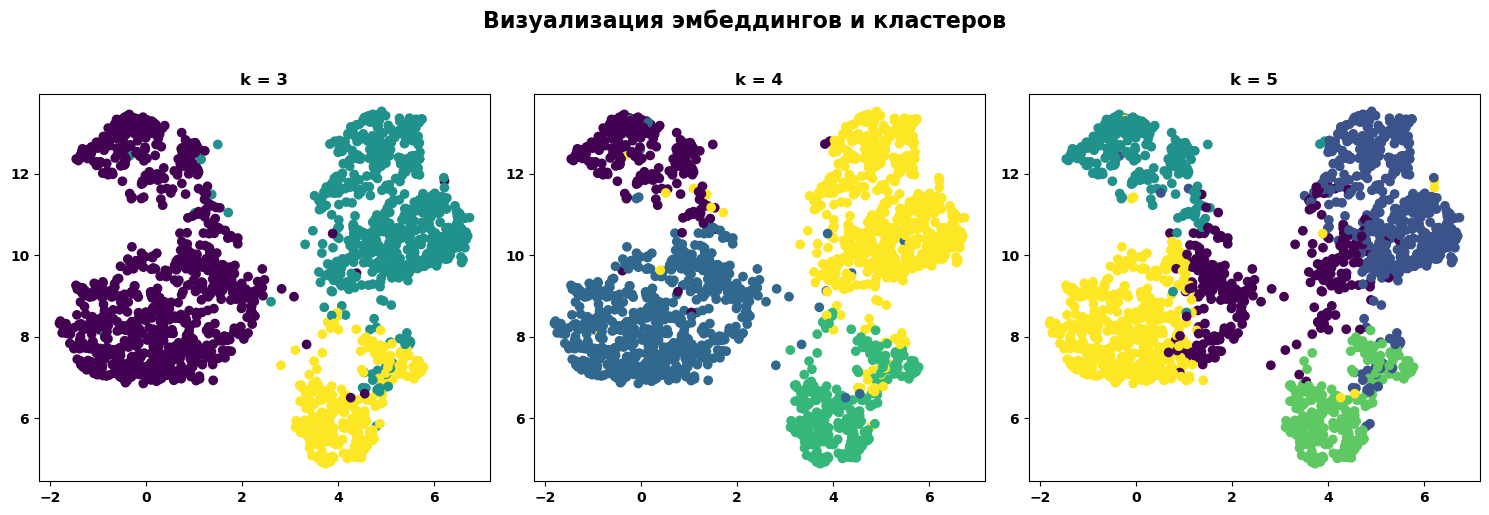

In [84]:
# Подбор кол-ва кластеров
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate([3, 4, 5]):
    clf_spectral = SpectralClustering(n_clusters=k,
                                  n_neighbors= 5,
                                  affinity='nearest_neighbors',
                                  assign_labels= 'kmeans',
                                  gamma=0.5,
                                  random_state=RAND)
    labels_spectral = clf_spectral.fit_predict(df_cleaned)

    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_spectral)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

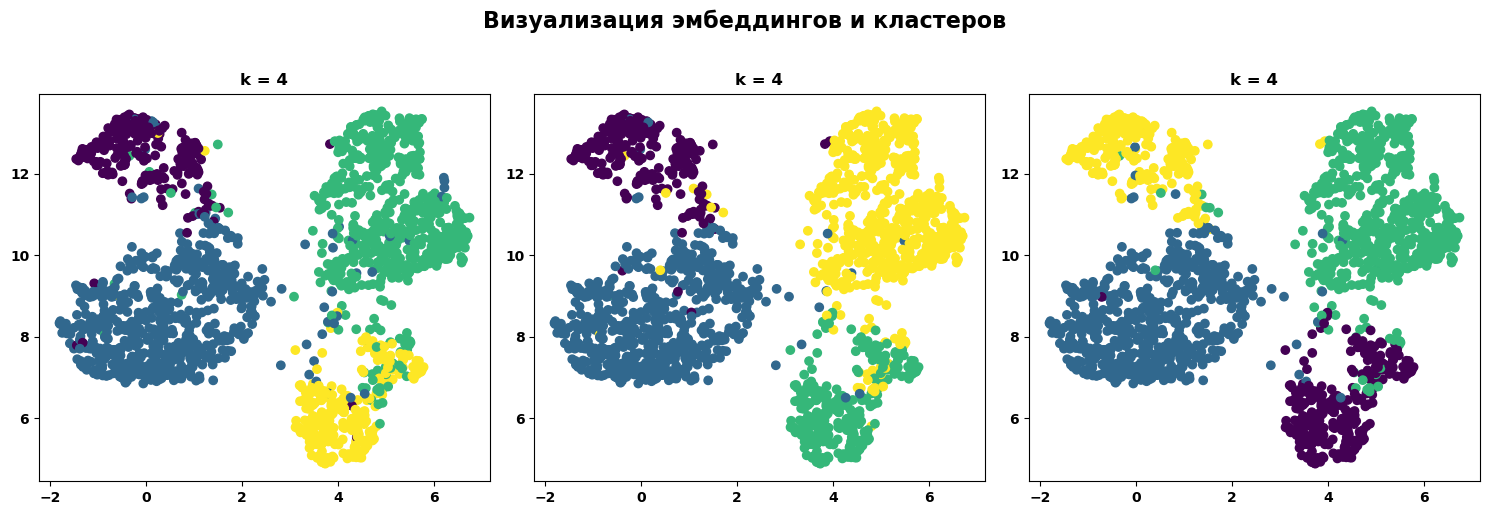

In [87]:
# Подбор кол-ва n_neighbors
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate([4, 5, 6]):
    clf_spectral = SpectralClustering(n_clusters=4,
                                  n_neighbors= k,
                                  affinity='nearest_neighbors',
                                  assign_labels= 'kmeans',
                                  gamma=0.5,
                                  random_state=RAND)
    labels_spectral = clf_spectral.fit_predict(df_cleaned)

    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_spectral)
    ax.set_title(f'k = {4}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

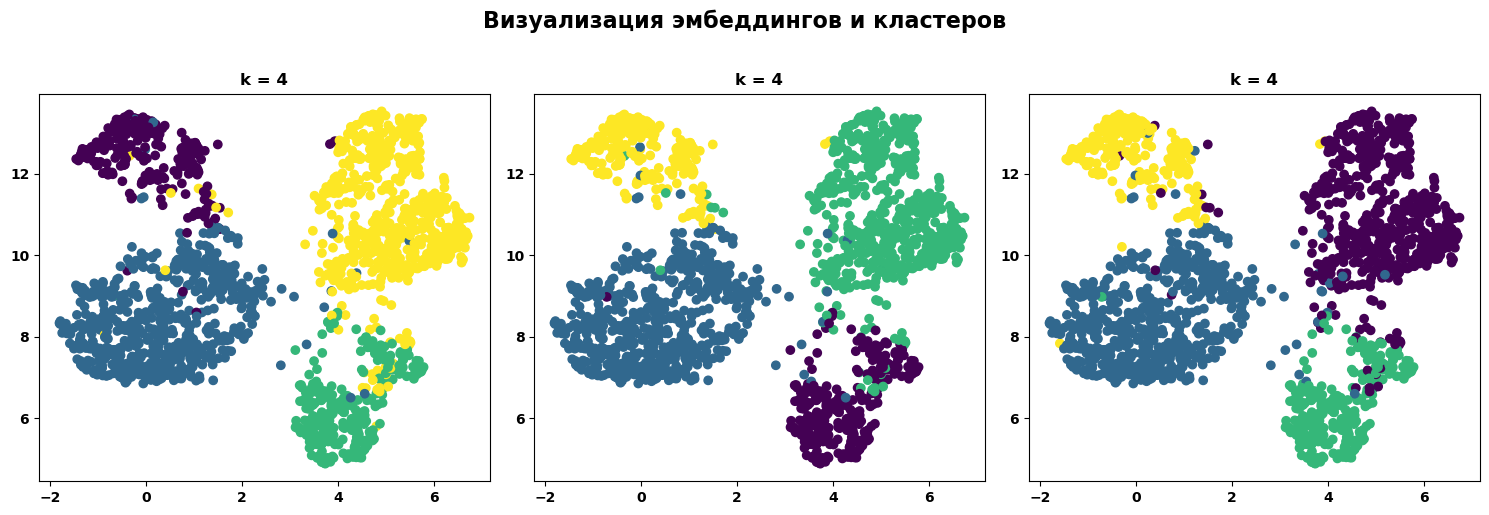

In [88]:
# Подбор кол-ва n_neighbors
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate([5, 6, 7]):
    clf_spectral = SpectralClustering(n_clusters=4,
                                  n_neighbors= k,
                                  affinity='nearest_neighbors',
                                  assign_labels= 'kmeans',
                                  gamma=0.5,
                                  random_state=RAND)
    labels_spectral = clf_spectral.fit_predict(df_cleaned)

    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_spectral)
    ax.set_title(f'k = {4}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

In [89]:
# конечная модель
#значение гамма не влияет на результат разбиения
clf_spectral = SpectralClustering(n_clusters=4,
                                  n_neighbors= 6,
                                  affinity='nearest_neighbors',
                                  assign_labels= 'kmeans',
                                  gamma=0.5, 
                                  random_state=RAND)
labels_spectral = clf_spectral.fit_predict(df_cleaned)

In [90]:
spectral_final = df_cleaned.assign(target=labels_spectral)
spectral_final['target'].value_counts()

1    712
2    656
0    343
3    286
Name: target, dtype: int64

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 4')

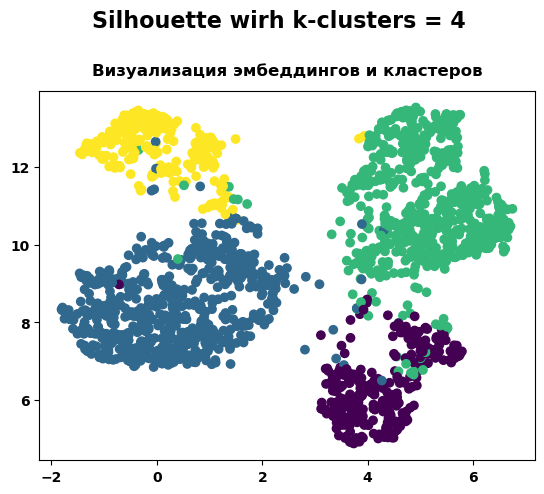

In [91]:
plt.scatter(clean_df_embedding[:, 0],
            clean_df_embedding[:, 1],
            c=labels_spectral)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {4}', fontsize=16, y=1.05)

После подбора параметров спектральная кластеризация показала очень хороший результат

<AxesSubplot: xlabel='target'>

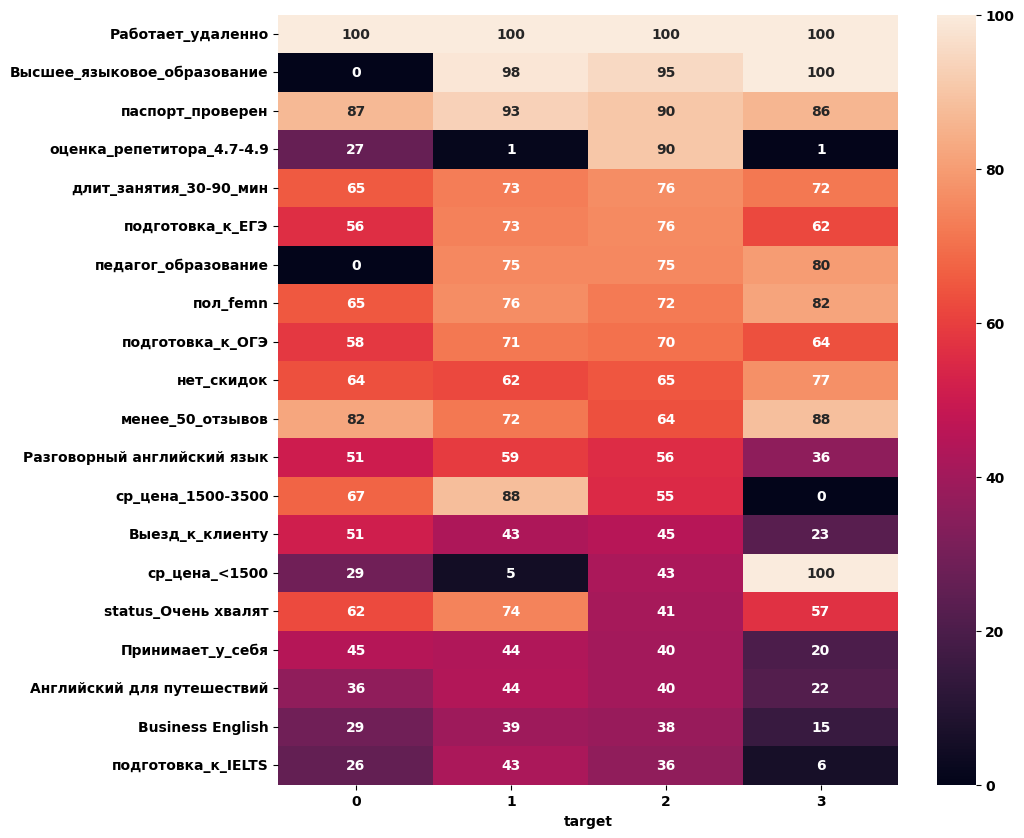

In [92]:
count = spectral_final.groupby('target').count().iloc[:, :1].T.values
normalize = spectral_final.groupby('target').sum().T / count * 100

plt.figure(figsize=(10, 10))

sns.heatmap(normalize.sort_values(by=2, ascending=False)[:20],
            fmt='.0f',
            annot=True)

## Agglomerative

In [176]:
from sklearn.metrics import homogeneity_score, calinski_harabasz_score

In [187]:
# используем n_clusters
param_grid_aggl = {
    'n_clusters': [3, 4, 5],
    'affinity': ['euclidean', 'manhattan', 'cosine', 'l1', 'l2'],
#     'affinity': ['euclidean'],
    'linkage': ['ward', 'complete', 'average', 'single'],
#     'linkage': ['ward'],
    'distance_threshold': [None]
#     'random_state': [RAND]
}
scorer=make_scorer(homogeneity_score)
clf_aggl = AgglomerativeClustering()
grid_cv = GridSearchCV(estimator = clf_aggl,
                   param_grid = param_grid_aggl,
#                        scoring=make_scorer(silhouette_score),
                       scoring=scorer,
                       verbose=1)

In [188]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 15.6 s


GridSearchCV(estimator=AgglomerativeClustering(),
             param_grid={'affinity': ['euclidean', 'manhattan', 'cosine', 'l1',
                                      'l2'],
                         'distance_threshold': [None],
                         'linkage': ['ward', 'complete', 'average', 'single'],
                         'n_clusters': [3, 4, 5]},
             scoring=make_scorer(homogeneity_score), verbose=1)

In [189]:
grid_cv.best_params_

{'affinity': 'euclidean',
 'distance_threshold': None,
 'linkage': 'ward',
 'n_clusters': 3}

Параметр grid_cv.best_score_ почему то всегда выводит nan (пробовала с разными моделями и метриками).

In [135]:
def custom_silhouette_score(estimator, X):
    n_clusters = estimator.get_params()['n_clusters']
    distance_threshold = estimator.get_params()['distance_threshold']
    
    if n_clusters is None:
        n_clusters_list = [3, 4, 5]
    else:
        n_clusters_list = [n_clusters]
    
    if distance_threshold is None:
        distance_threshold_list = [0.05, 0.5]
    else:
        distance_threshold_list = [distance_threshold]
    
    best_score = -1
    best_params = {}
    
    for n_cluster in n_clusters_list:
        for threshold in distance_threshold_list:
            estimator.set_params(n_clusters=n_cluster, distance_threshold=threshold)
            estimator.fit(X)
            
            labels = estimator.labels_
            silhouette = silhouette_score(X, labels)
            
            if silhouette > best_score:
                best_score = silhouette
                best_params = {'n_clusters': n_cluster, 'distance_threshold': threshold}
    
    return best_score

In [183]:
# используем distance_threshold
param_grid_aggl = {
    'n_clusters': [None],
    'affinity': ['euclidean', 'manhattan', 'cosine', 'l1', 'l2'],
    'linkage': ['ward', 'complete', 'average', 'single'],
#     'distance_threshold': [None, 0.05, 0.5],
    'distance_threshold': [0.05, 0.5],
#     'random_state': [RAND]
}

clf_aggl = AgglomerativeClustering()
grid_cv = GridSearchCV(clf_aggl,
                       param_grid_aggl,
                       scoring=make_scorer(custom_silhouette_score),
                       verbose=1)

In [184]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Wall time: 10.9 s


GridSearchCV(estimator=AgglomerativeClustering(),
             param_grid={'affinity': ['euclidean', 'manhattan', 'cosine', 'l1',
                                      'l2'],
                         'distance_threshold': [0.05, 0.5],
                         'linkage': ['ward', 'complete', 'average', 'single'],
                         'n_clusters': [None]},
             scoring=make_scorer(custom_silhouette_score), verbose=1)

In [185]:
grid_cv.best_params_

{'affinity': 'euclidean',
 'distance_threshold': 0.05,
 'linkage': 'ward',
 'n_clusters': None}

Разбираюсь с неработающим silhouette_score

In [203]:
param_grid_aggl = {
    'n_clusters': [3, 4, 5],
    'affinity': ['euclidean', 'manhattan', 'cosine', 'l1', 'l2'],
    'linkage': ['ward', 'complete', 'average', 'single'],
    'distance_threshold': [None],
#     'random_state': [RAND]
}

    
clf_aggl = AgglomerativeClustering()
grid_cv = GridSearchCV(clf_aggl,
                       param_grid_aggl,
                       scoring=(silhouette_score),
                       verbose=1)

In [204]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 15.6 s


GridSearchCV(estimator=AgglomerativeClustering(),
             param_grid={'affinity': ['euclidean', 'manhattan', 'cosine', 'l1',
                                      'l2'],
                         'distance_threshold': [None],
                         'linkage': ['ward', 'complete', 'average', 'single'],
                         'n_clusters': [3, 4, 5]},
             scoring=<function silhouette_score at 0x0000023CF4D725E0>,
             verbose=1)

In [205]:
grid_cv.best_params_

{'affinity': 'euclidean',
 'distance_threshold': None,
 'linkage': 'ward',
 'n_clusters': 3}

In [206]:
grid_cv.best_score_

nan

In [22]:
clf_aggl_clust = AgglomerativeClustering(n_clusters=3,
                                         affinity='euclidean',
                                         linkage='ward')
aggl_labels = clf_aggl_clust.fit_predict(df_cleaned)

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

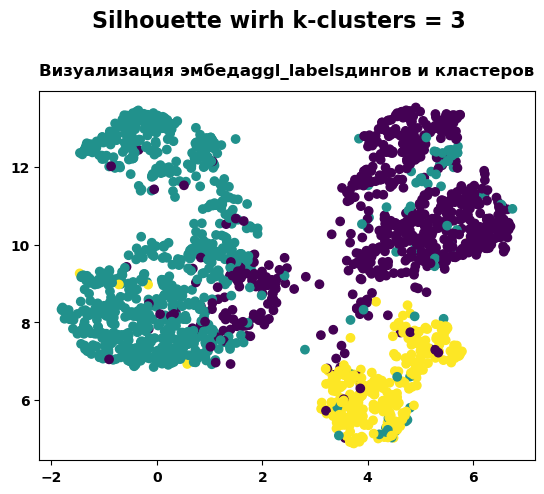

In [23]:
plt.scatter(clean_df_embedding[:, 0],
            clean_df_embedding[:, 1],
            c=aggl_labels)
plt.title('Визуализация эмбедaggl_labelsдингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}', fontsize=16, y=1.05)

In [157]:
param_grid_n_clusters = {
    'n_clusters': [3, 4, 5],
    'affinity': ['euclidean', 'manhattan', 'cosine']
}

param_grid_distance_threshold = {
    'distance_threshold': [None, 0.5, 1.0],
    'affinity': ['euclidean', 'manhattan', 'cosine']
}

clf_aggl = AgglomerativeClustering()

grid_cv_n_clusters = GridSearchCV(clf_aggl,
                                  param_grid_n_clusters,
                                  scoring=make_scorer(silhouette_score),
                                  verbose=1)

grid_cv_distance_threshold = GridSearchCV(clf_aggl,
                                          param_grid_distance_threshold,
                                          scoring=make_scorer(silhouette_score),
                                          verbose=1)

grid_cv_n_clusters.fit(df_cleaned)
grid_cv_distance_threshold.fit(df_cleaned)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=AgglomerativeClustering(),
             param_grid={'affinity': ['euclidean', 'manhattan', 'cosine'],
                         'distance_threshold': [None, 0.5, 1.0]},
             scoring=make_scorer(silhouette_score), verbose=1)

In [159]:
best_params_n_clusters

{'affinity': 'euclidean', 'n_clusters': 3}

In [160]:
best_params_distance_threshold

{'affinity': 'euclidean', 'distance_threshold': None}

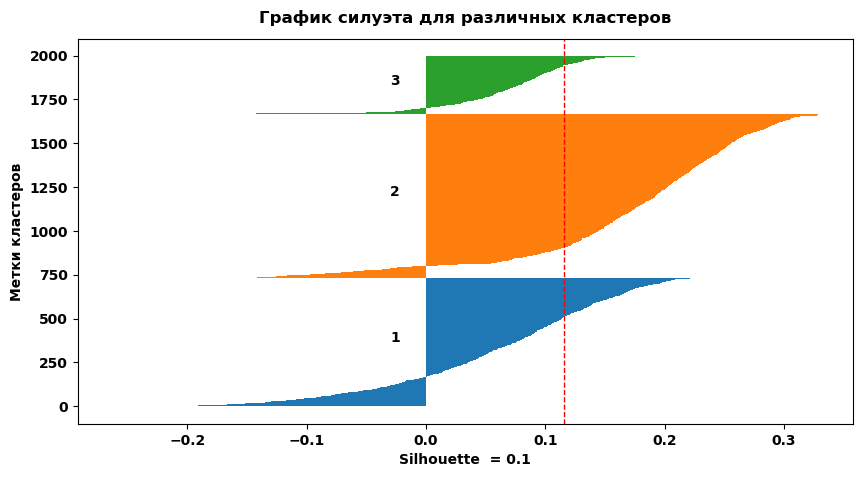

In [168]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

aggl = AgglomerativeClustering(n_clusters=3, affinity='euclidean')
aggl.fit(df_cleaned)

# Получение метрики - силуэтный скор
silhouette_vals = silhouette_score(df_cleaned,
                                       aggl.labels_,
                                       metric='cosine')
# Добавление средней оценки силуэтного скора
silhouette_list.append(silhouette_vals)
# Построение графика силуэтного коэффициента
silhouette_plot(df_cleaned, aggl.labels_, ax=ax, metric = 'cosine')

# # Построение графика зависимости silhouette от кол-ва кластеров
# metric_picture(silhouette_list,
#                min_size,
#                max_size,
#                name_metric='Silhouette mean',
#                optimal=False)

In [63]:
clf_aggl_clust = AgglomerativeClustering(n_clusters=4)
aggl_labels = clf_aggl_clust.fit_predict(df_cleaned)

df_agl_clust = df_cleaned.assign(target=aggl_labels)
df_agl_clust[:4]

Принимает_у_себя  Выезд_к_клиенту  Работает_удаленно  Носитель английского  \
0                 1                1                  1                     1   
1                 0                0                  1                     0   
2                 0                0                  1                     0   
3                 1                0                  1                     0   

   стажировка в США  стажировка в Англии  переводчик  лингвист  \
0                 0                    0           0         0   
1                 0                    0           0         1   
2                 0                    0           1         0   
3                 1                    0           1         1   

   подготовка_к_IELTS  подготовка_к_IELTS_Academic  ...  менее_50_отзывов  \
0                   1                            1  ...                 0   
1                   1                            0  ...                 0   
2                   1                            0  ...                 0   
3                   1                            1  ...                 0   

   ср_цена_1500-3500  ср_цена_<1500  ср_цена_>3500  \
0                  1              0              0   
1                  1              0              0   
2                  1              0              0   
3                  1              0              0   

   уровень_знаний_подтверждён  нет_скидок  паспорт_проверен  \
0                           1           1                 1   
1                           1           1                 1   
2                           1           1                 1   
3                           0           0                 1   

   доля_плохих_отзывов_10%_и_более  отзывов_5_звезд_больше_95%  target  
0                                0                           0       3  
1                                0                           0       1  
2                                0                           1       0  
3                                0                           1       3  

[4 rows x 53 columns]

In [64]:
df_agl_clust['target'].value_counts()

0    936
1    529
2    331
3    201
Name: target, dtype: int64

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 4')

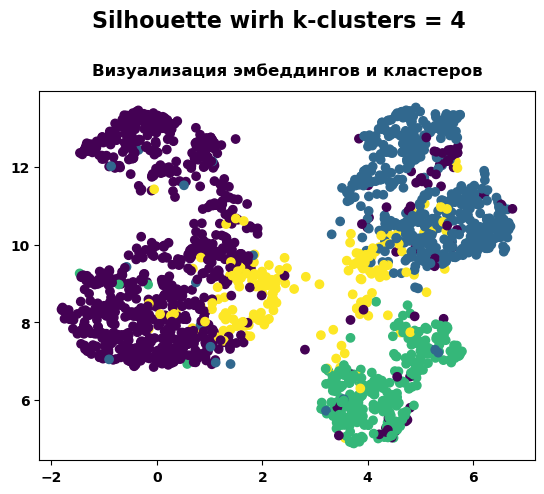

In [67]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=aggl_labels)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {4}',
             fontsize=16,
             y=1.05)

## GMM

In [24]:
from sklearn.mixture import GaussianMixture

  0%|          | 0/7 [00:00<?, ?it/s]

2 clusters
----------------------------------------------------------------------------------------------------


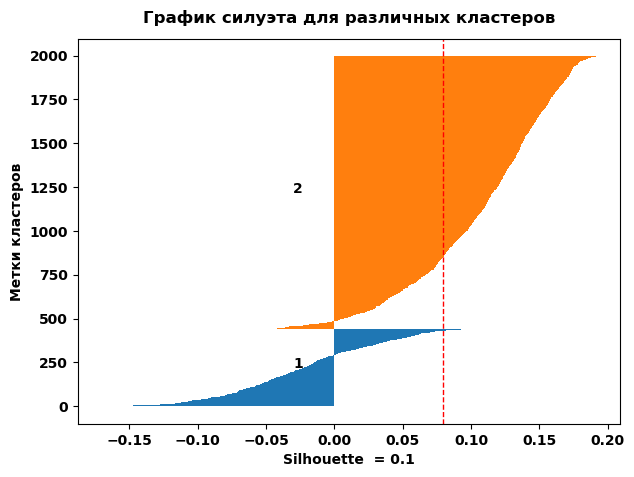

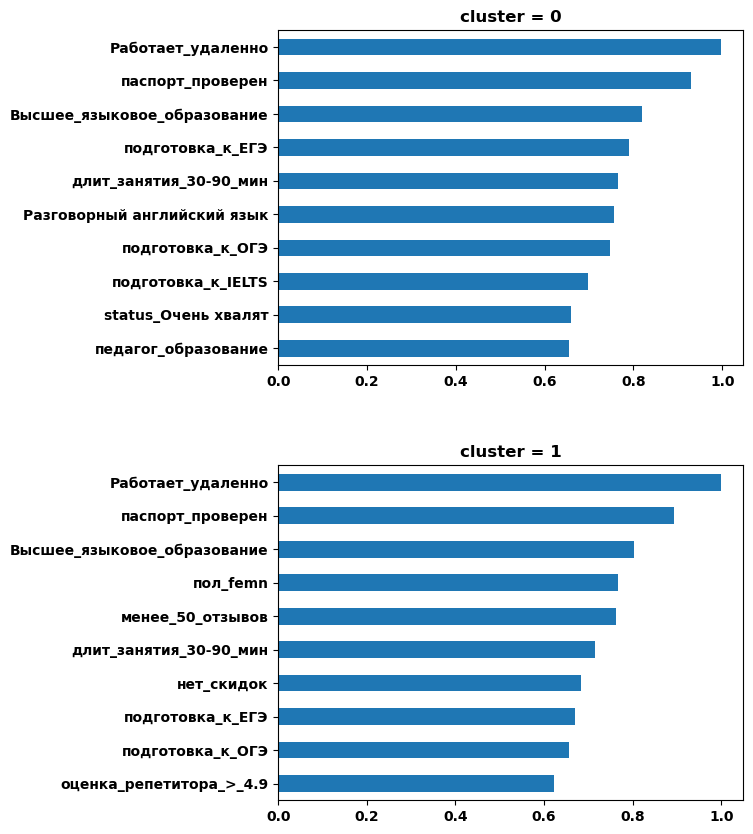

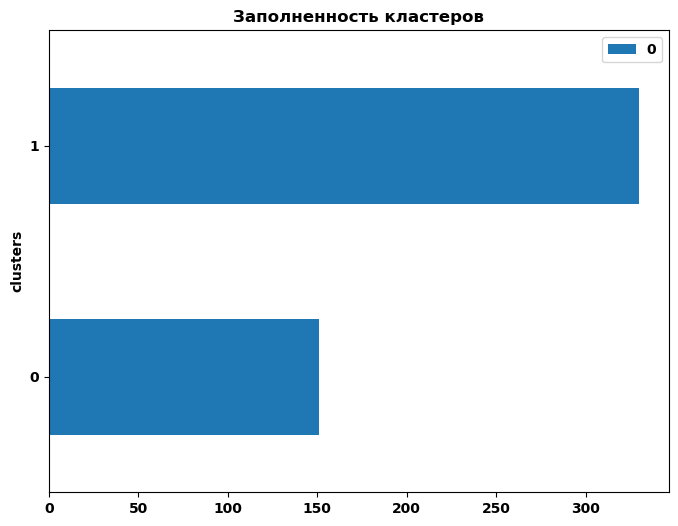

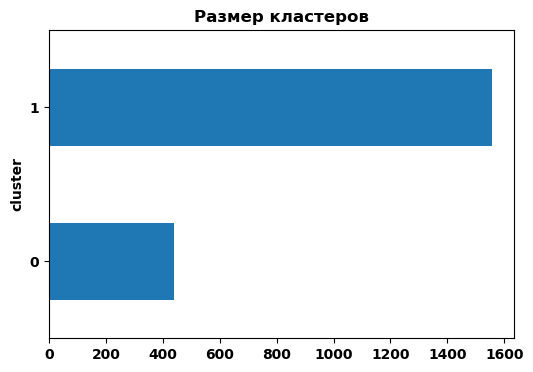

3 clusters
----------------------------------------------------------------------------------------------------


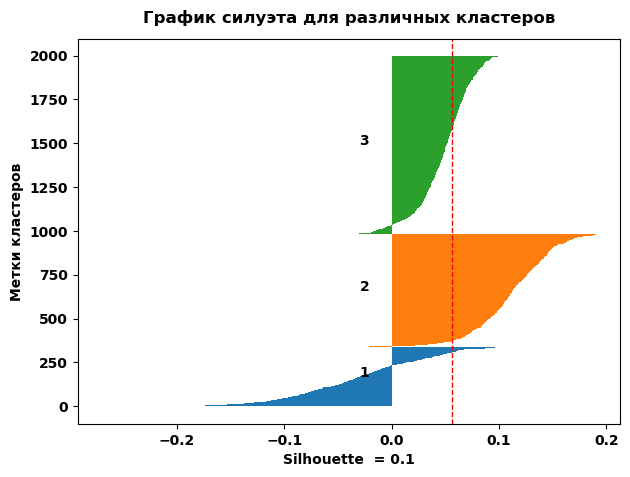

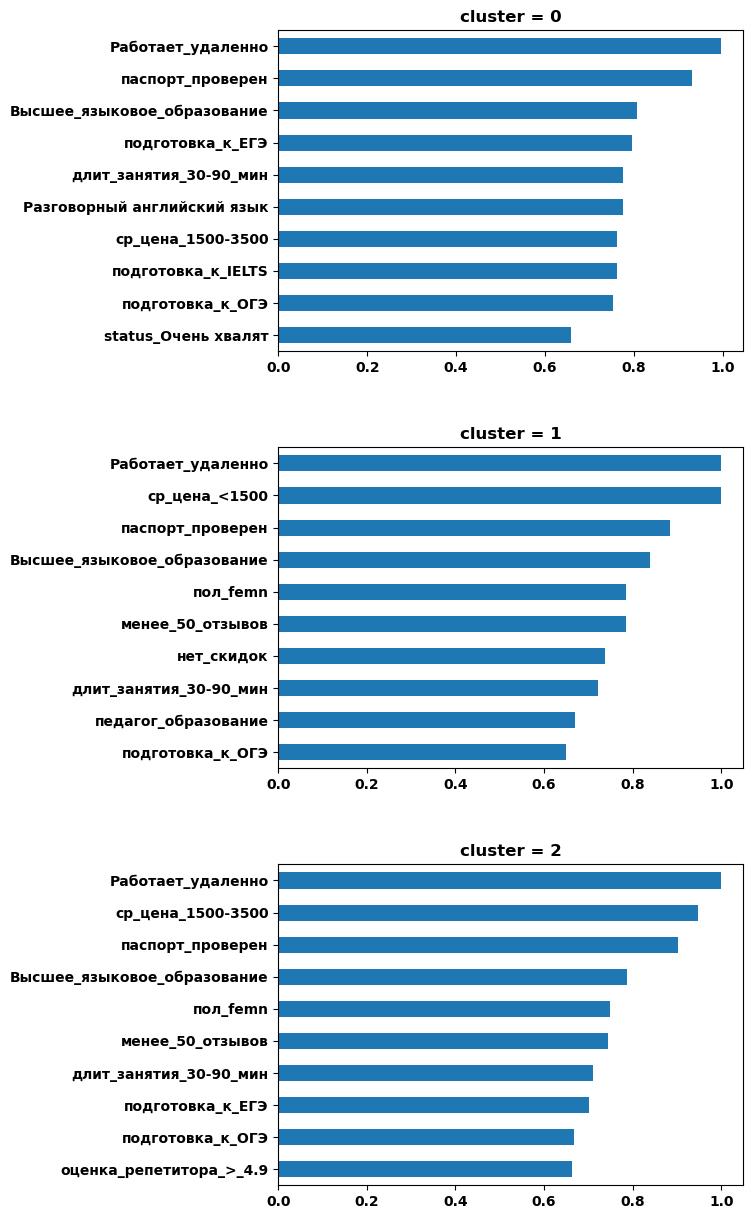

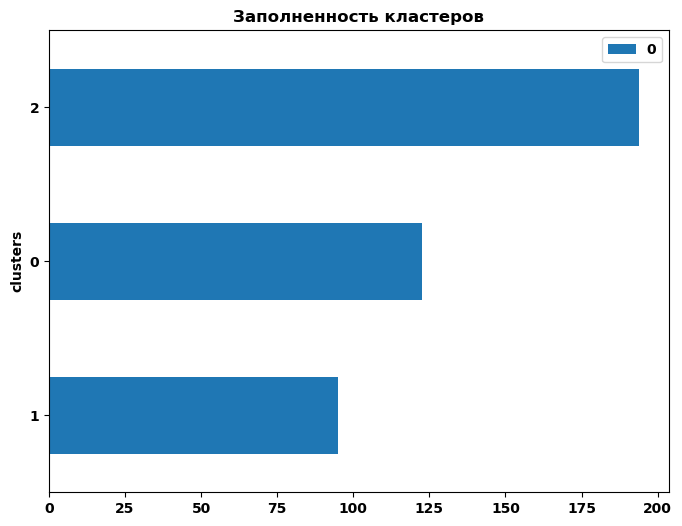

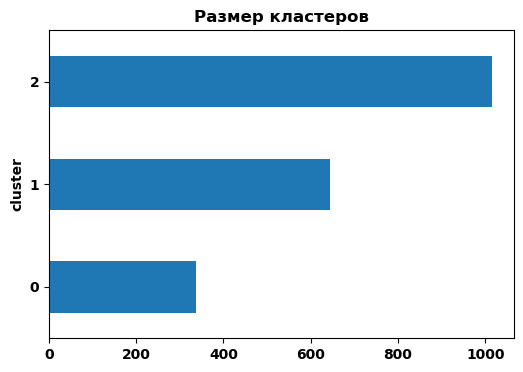

4 clusters
----------------------------------------------------------------------------------------------------


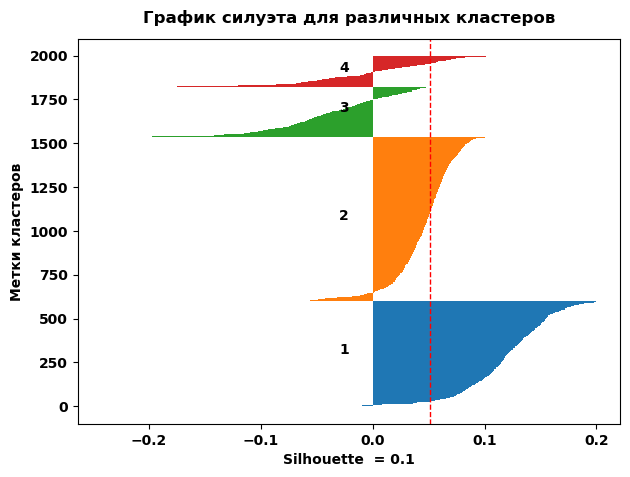

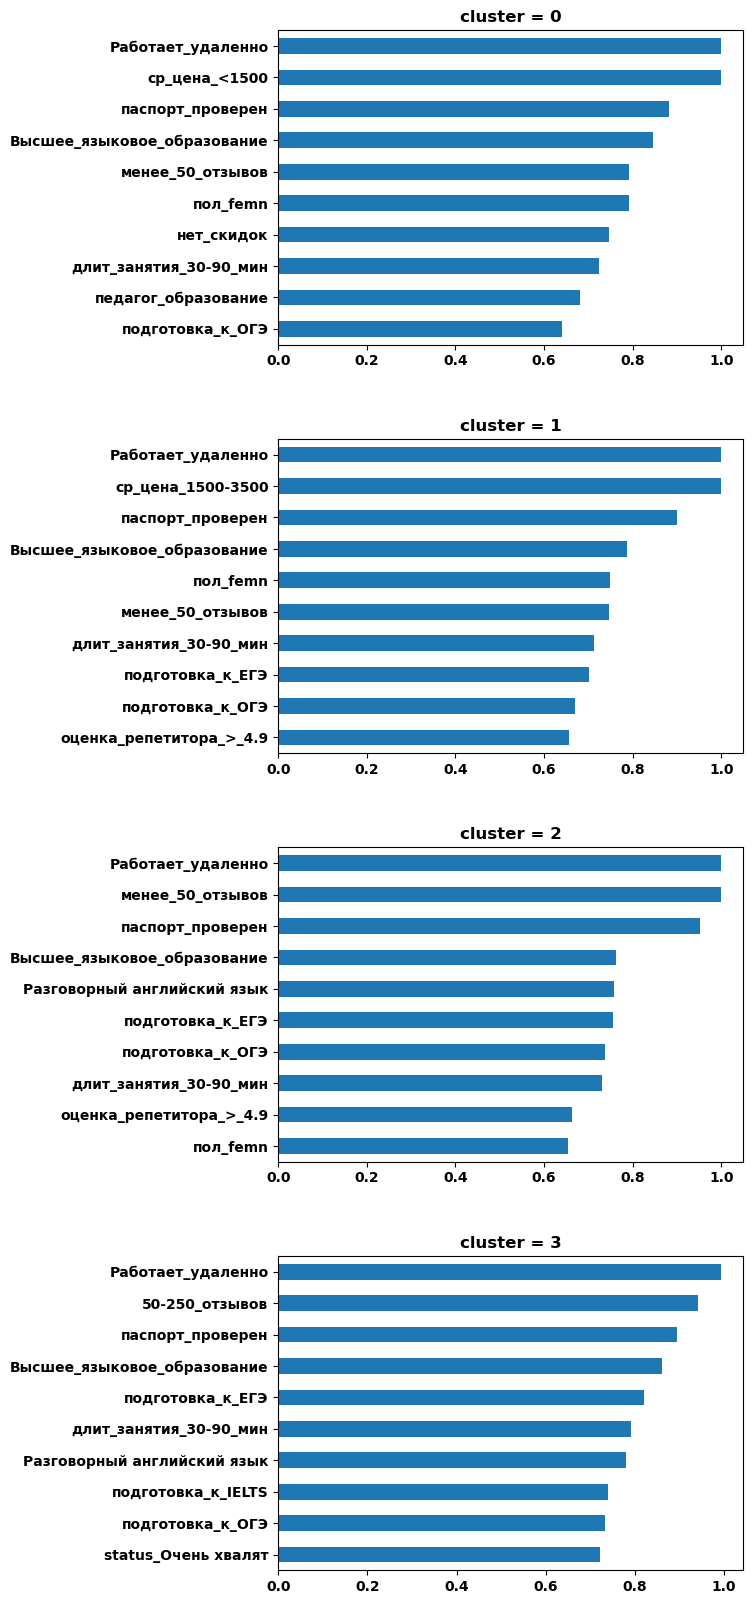

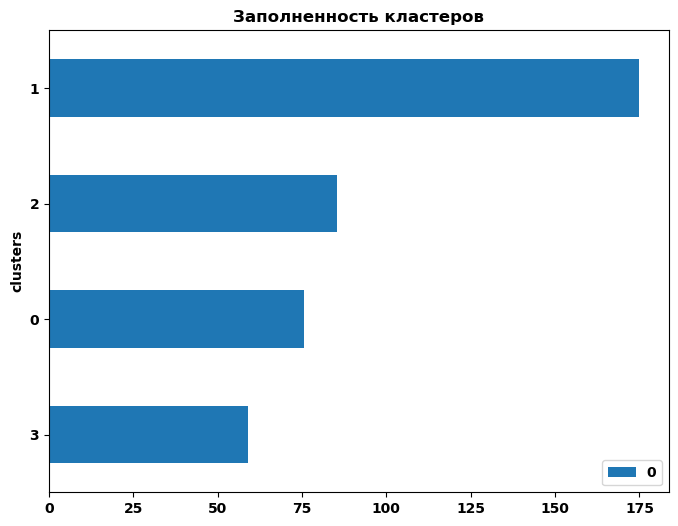

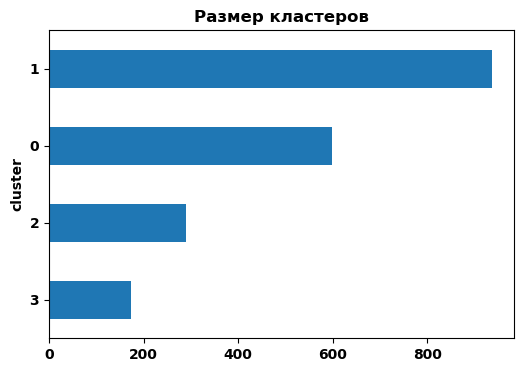

5 clusters
----------------------------------------------------------------------------------------------------


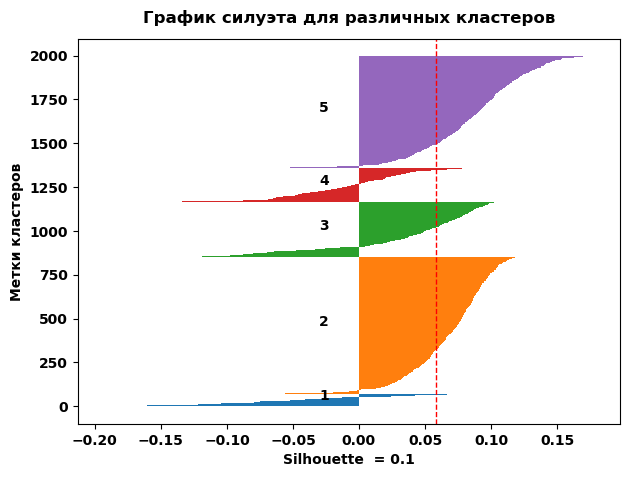

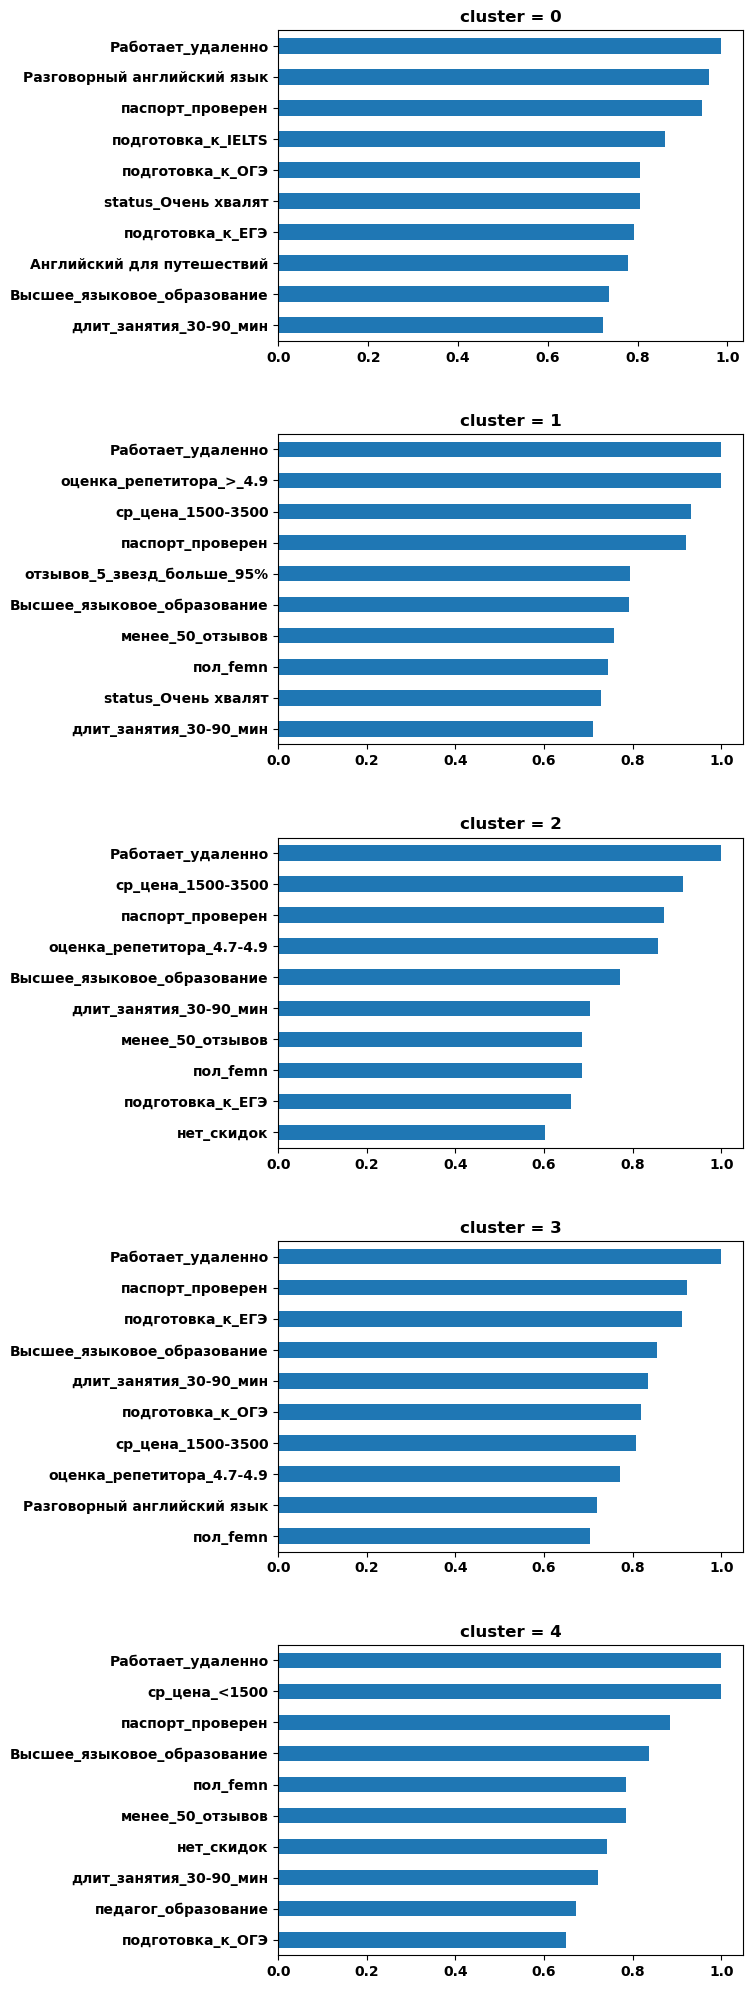

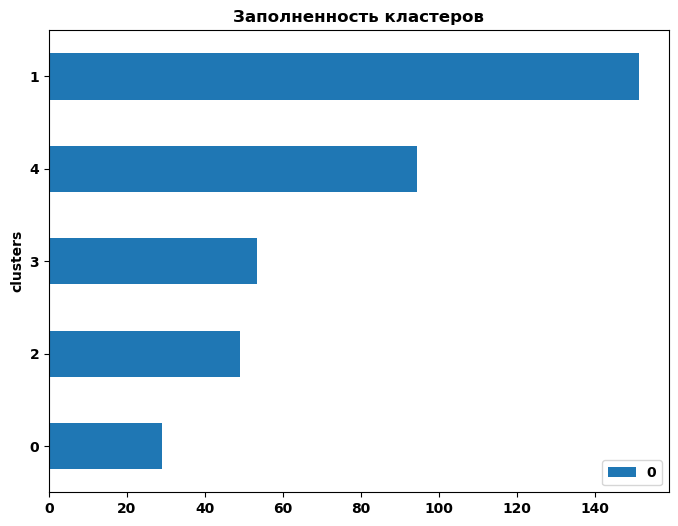

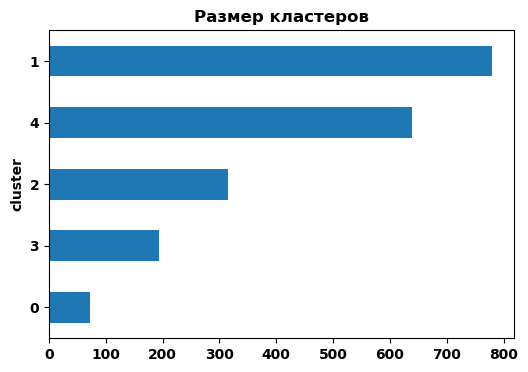

6 clusters
----------------------------------------------------------------------------------------------------


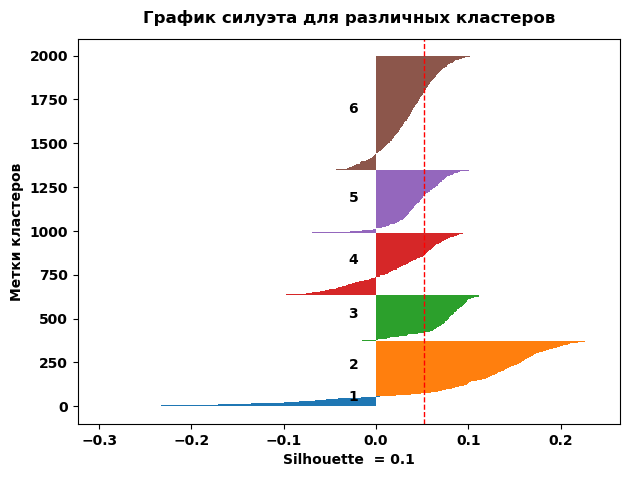

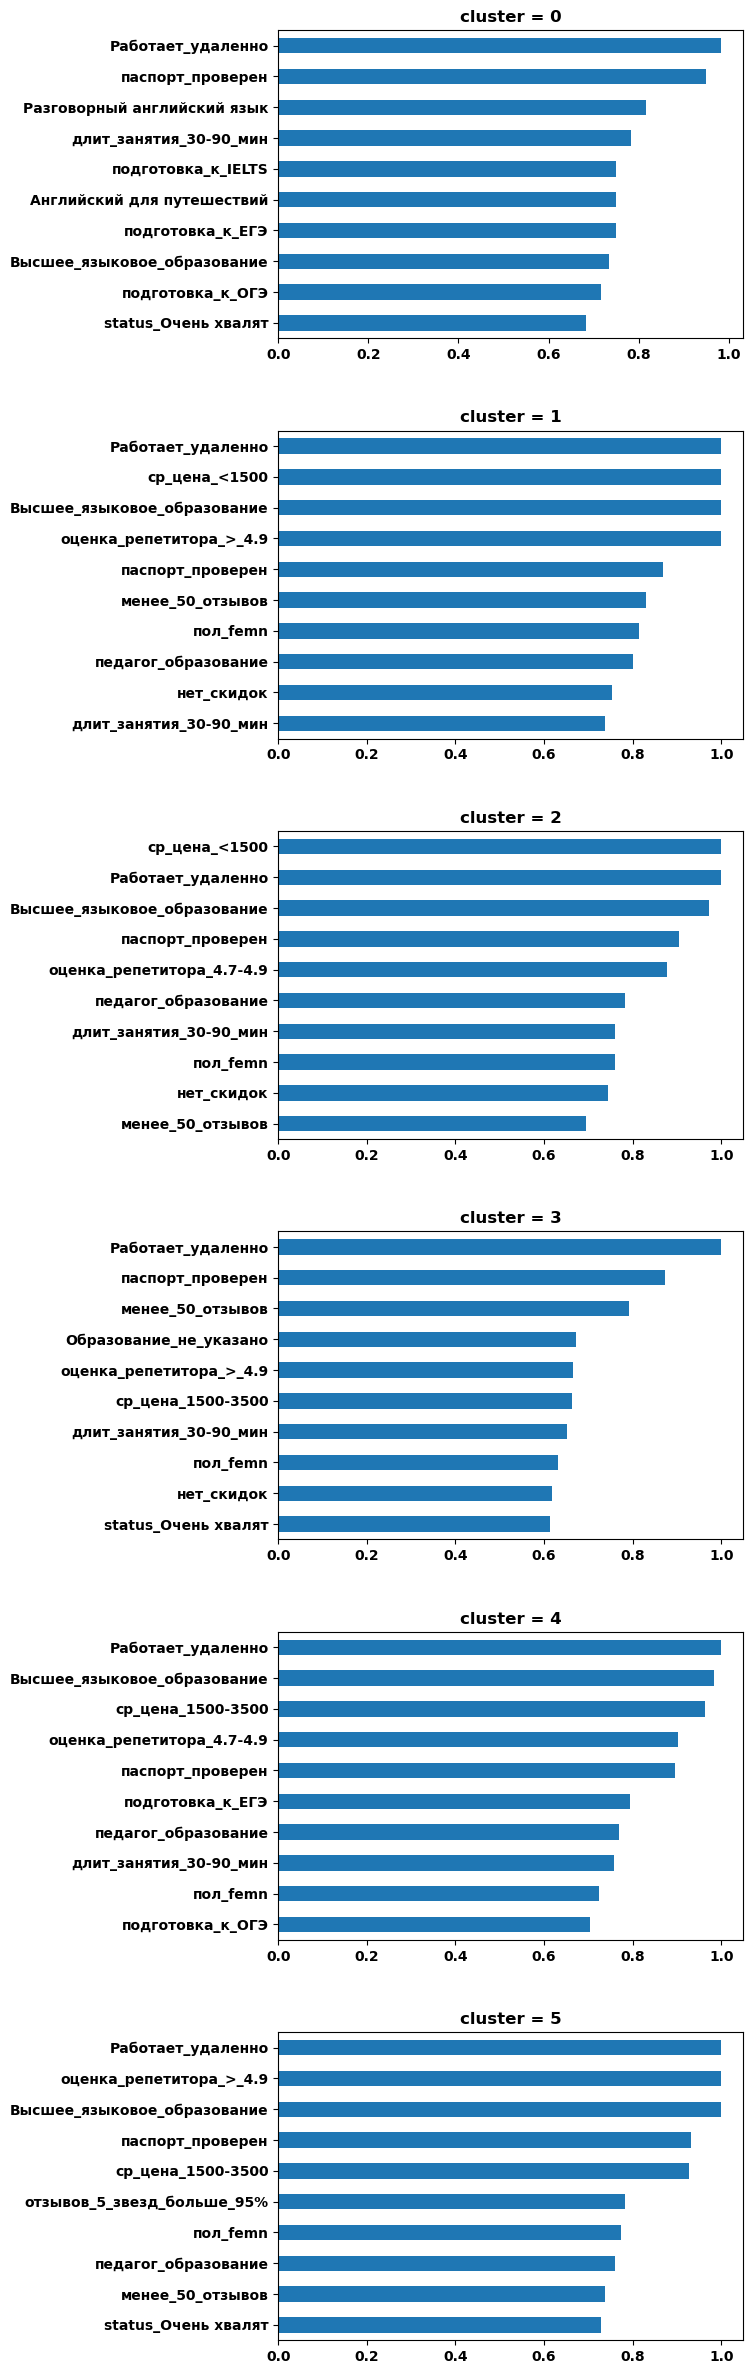

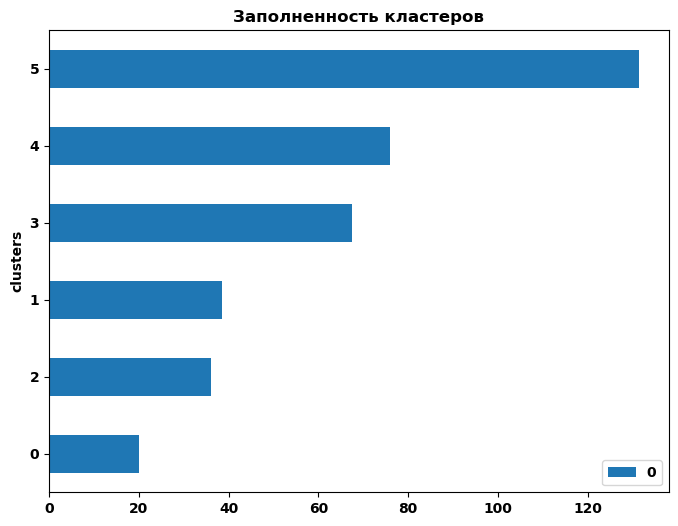

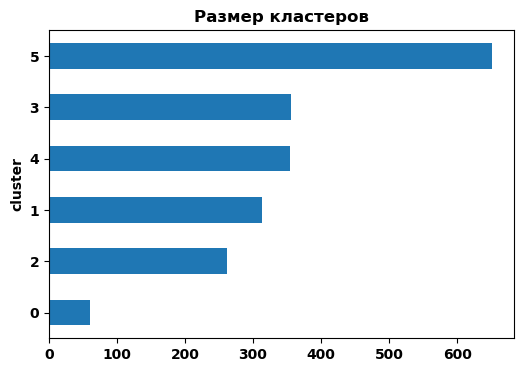

7 clusters
----------------------------------------------------------------------------------------------------


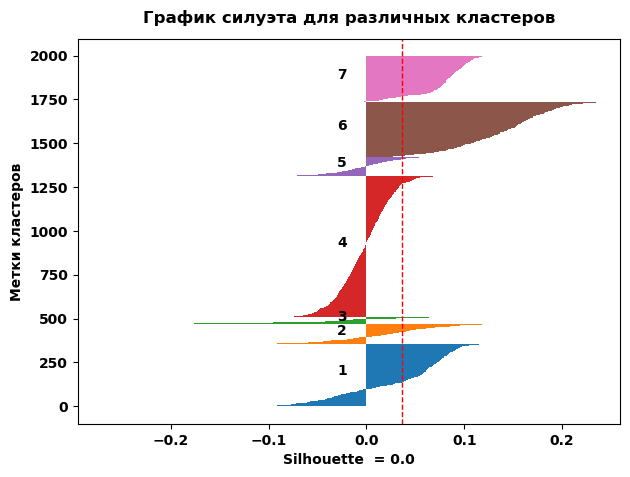

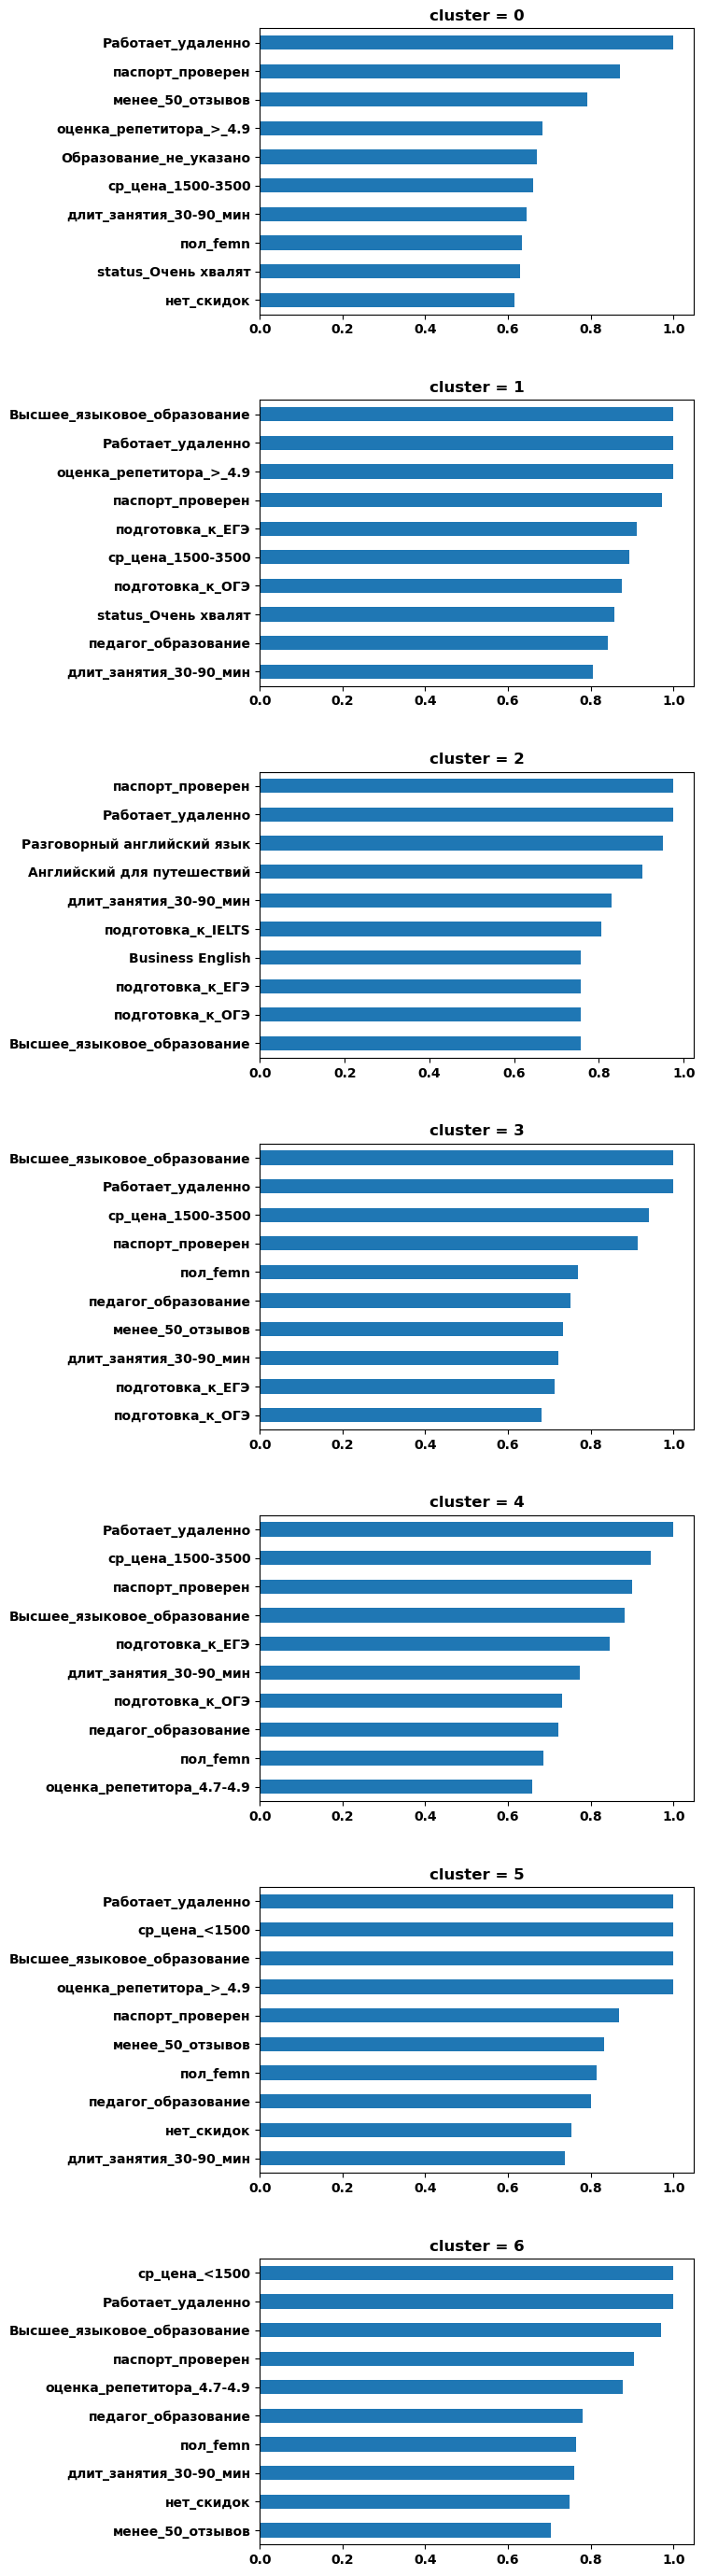

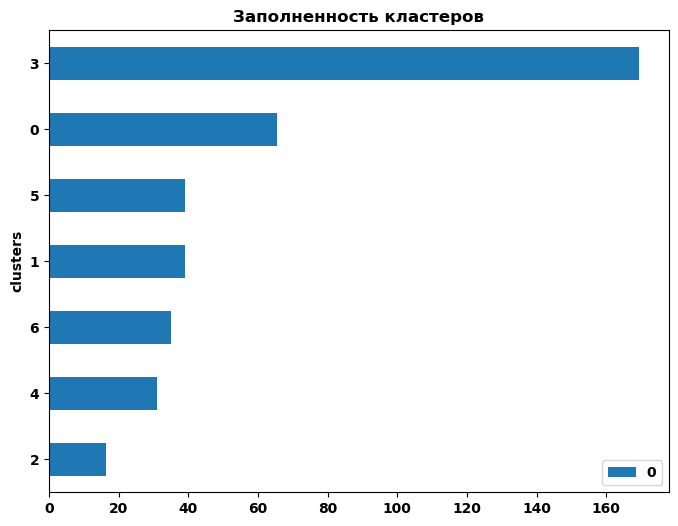

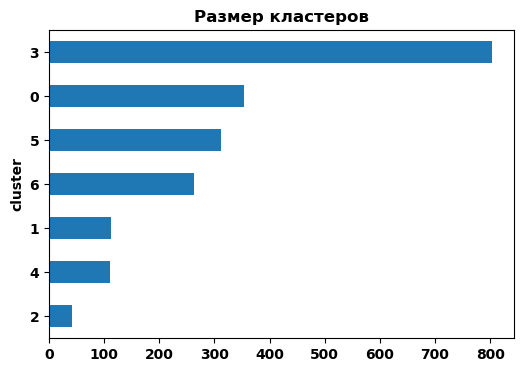

8 clusters
----------------------------------------------------------------------------------------------------


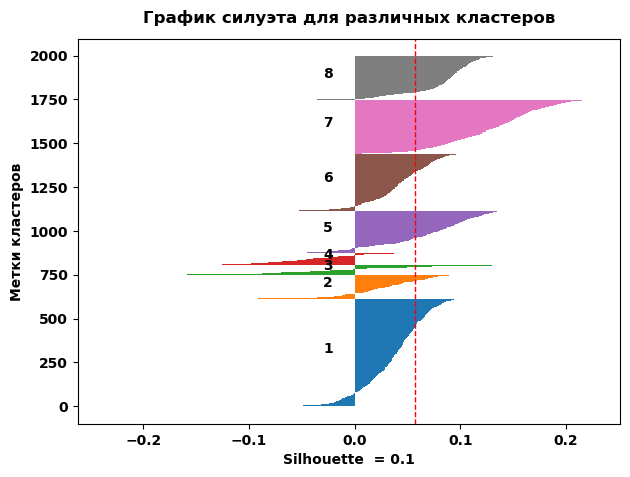

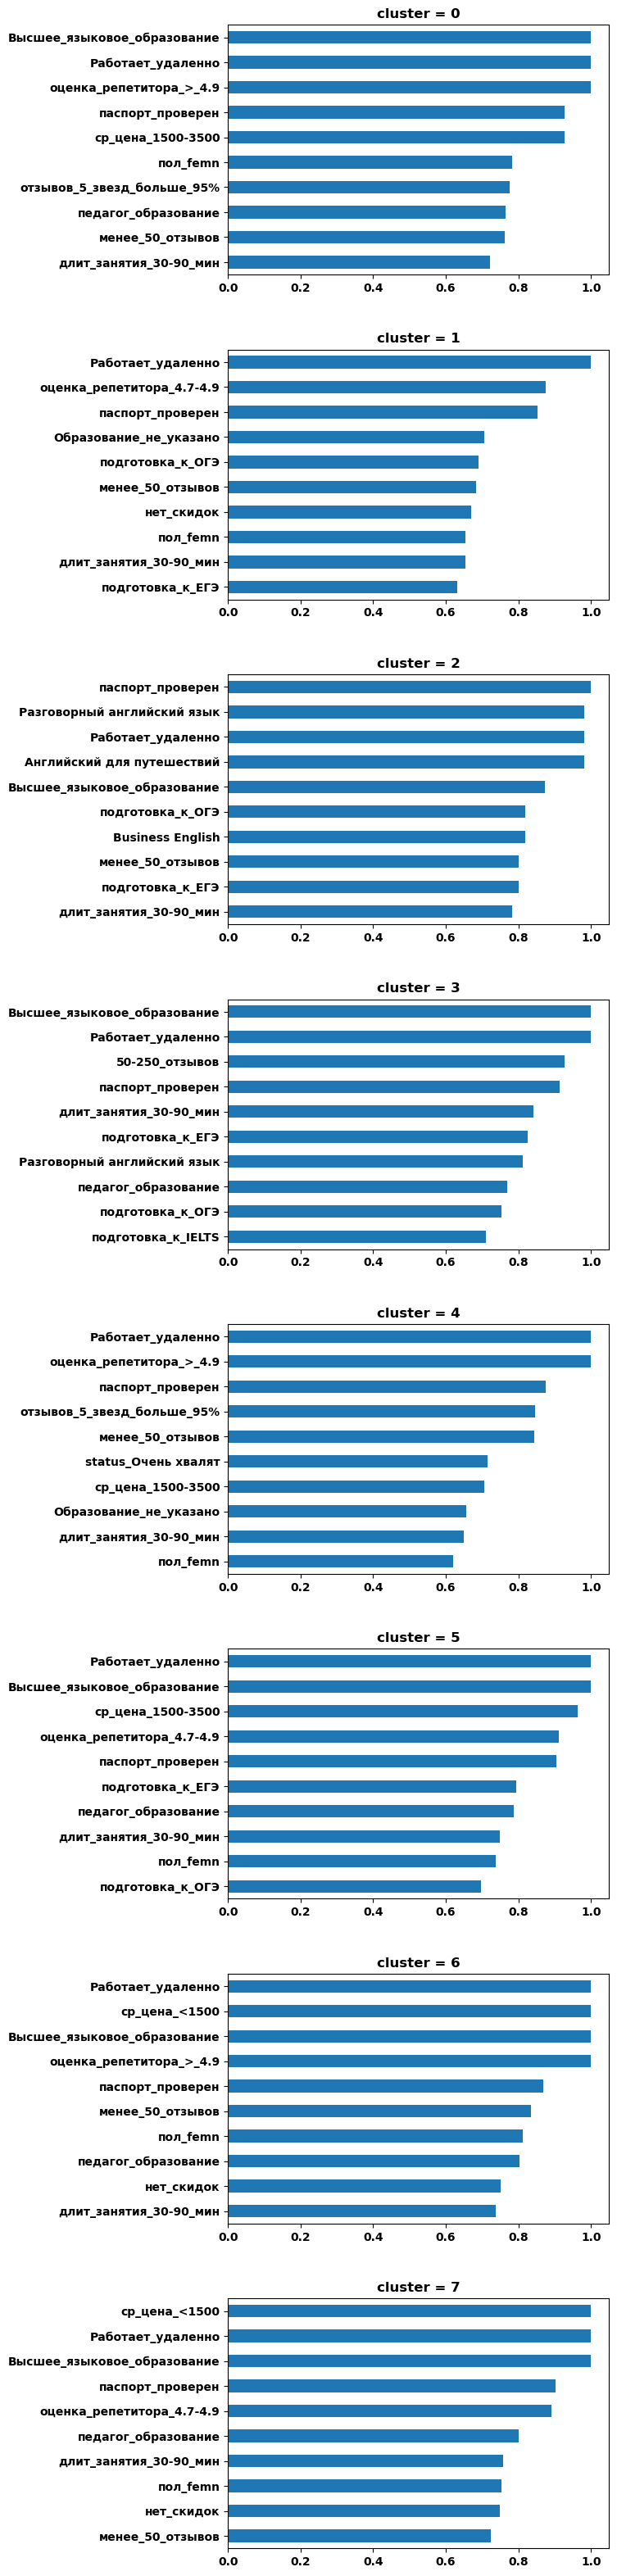

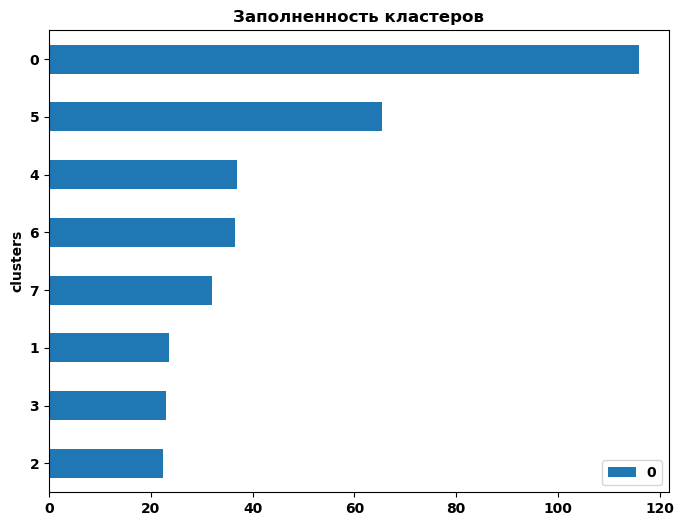

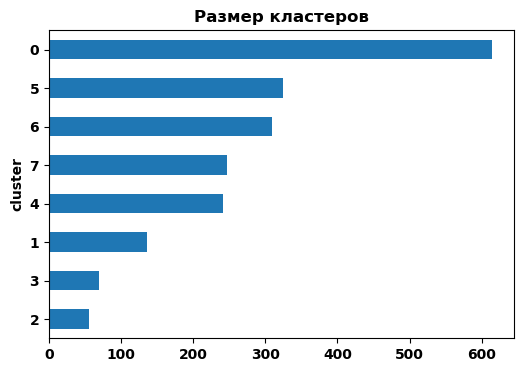

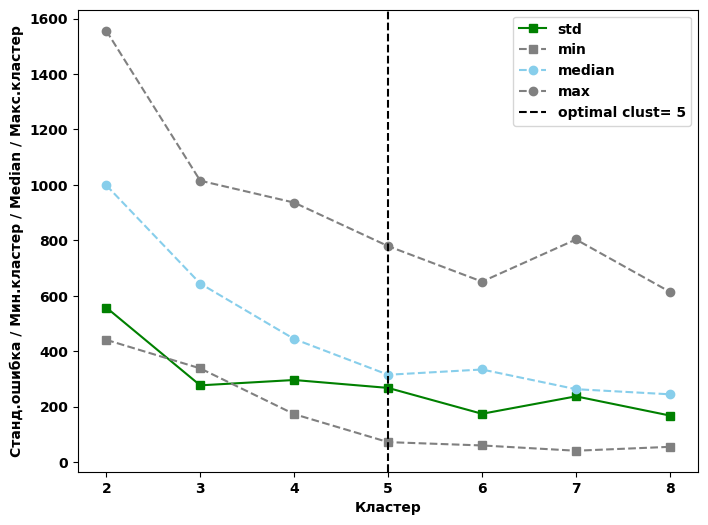

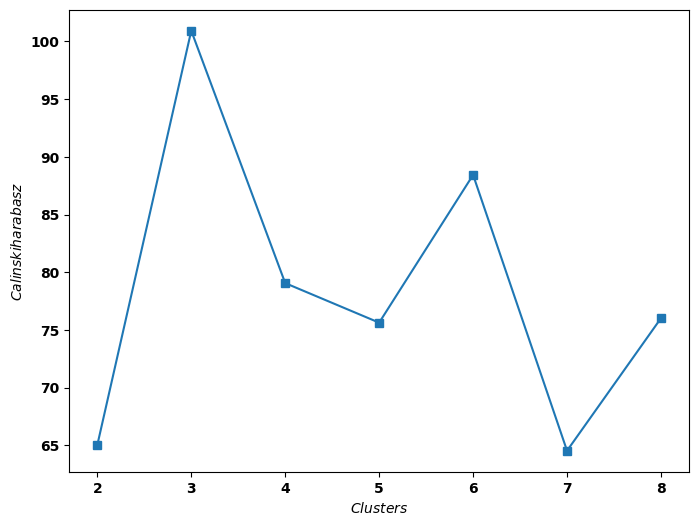

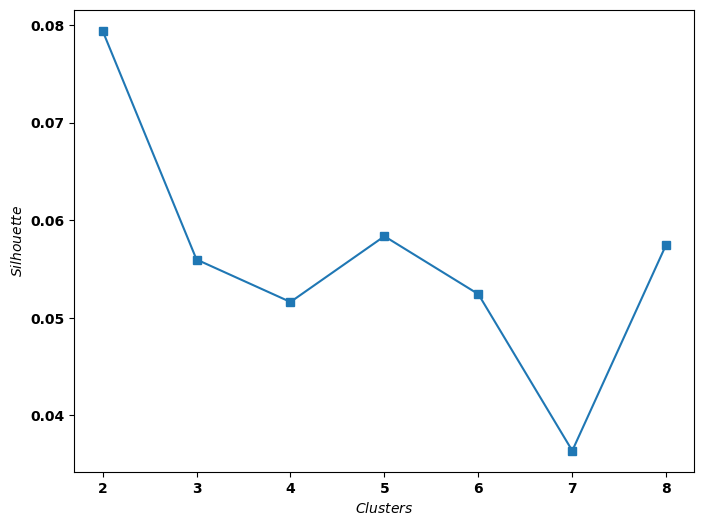

In [81]:
labels_std = []
labels_min = []
labels_max = []
labels_median = []

min_size = 2
max_size = 8
calinski_harabasz = []
silhouette_list = []

for clust in tqdm_notebook(range(min_size, max_size + 1)):
    clf = GaussianMixture(n_components=clust)
    labels = clf.fit_predict(df_cleaned)
    print(clust, 'clusters')
    print('-' * 100)

    # график silhouette
    silhouette_plot(df_cleaned, labels)
    # топ-признаков
    plot_top_features(df_cleaned, labels, clust)
    # медианная заполненность
    check_fullness(df_cleaned, labels)
    # размер кластеров
    plot_size(df_cleaned, labels)

    # calinski_harabasz
    calinski_harabasz.append(calinski_harabasz_score(df_cleaned, labels))
    # silhouette
    silhouette_list.append(silhouette_score(df_cleaned, labels))
    _, counts = np.unique(labels, return_counts=True)

    labels_std.append(np.std(counts))
    labels_min.append(np.min(counts))
    labels_max.append(np.max(counts))
    labels_median.append(np.median(counts))

elbow_picture(labels_std, labels_min, labels_max, labels_median, labels_median,
              min_size, max_size)
metric_picture(calinski_harabasz,
               min_size,
               max_size,
               name_metric='Calinski harabasz',
               optimal=False)
metric_picture(silhouette_list,
               min_size,
               max_size,
               name_metric='Silhouette',
               optimal=False)


In [116]:
gmm=GaussianMixture(n_components=4)
labels_gmm=gmm.fit_predict(df_cleaned)

In [117]:
gmm_final = df_cleaned.assign(target=labels_gmm)
gmm_final[:4]

Принимает_у_себя  Выезд_к_клиенту  Работает_удаленно  Носитель английского  \
0                 1                1                  1                     1   
1                 0                0                  1                     0   
2                 0                0                  1                     0   
3                 1                0                  1                     0   

   стажировка в США  стажировка в Англии  переводчик  лингвист  \
0                 0                    0           0         0   
1                 0                    0           0         1   
2                 0                    0           1         0   
3                 1                    0           1         1   

   подготовка_к_IELTS  подготовка_к_IELTS_Academic  ...  менее_50_отзывов  \
0                   1                            1  ...                 0   
1                   1                            0  ...                 0   
2                   1                            0  ...                 0   
3                   1                            1  ...                 0   

   ср_цена_1500-3500  ср_цена_<1500  ср_цена_>3500  \
0                  1              0              0   
1                  1              0              0   
2                  1              0              0   
3                  1              0              0   

   уровень_знаний_подтверждён  нет_скидок  паспорт_проверен  \
0                           1           1                 1   
1                           1           1                 1   
2                           1           1                 1   
3                           0           0                 1   

   доля_плохих_отзывов_10%_и_более  отзывов_5_звезд_больше_95%  target  
0                                0                           0       2  
1                                0                           0       0  
2                                0                           1       1  
3                                0                           1       2  

[4 rows x 53 columns]

In [118]:
gmm_final['target'].value_counts()

1    915
0    595
3    375
2    112
Name: target, dtype: int64

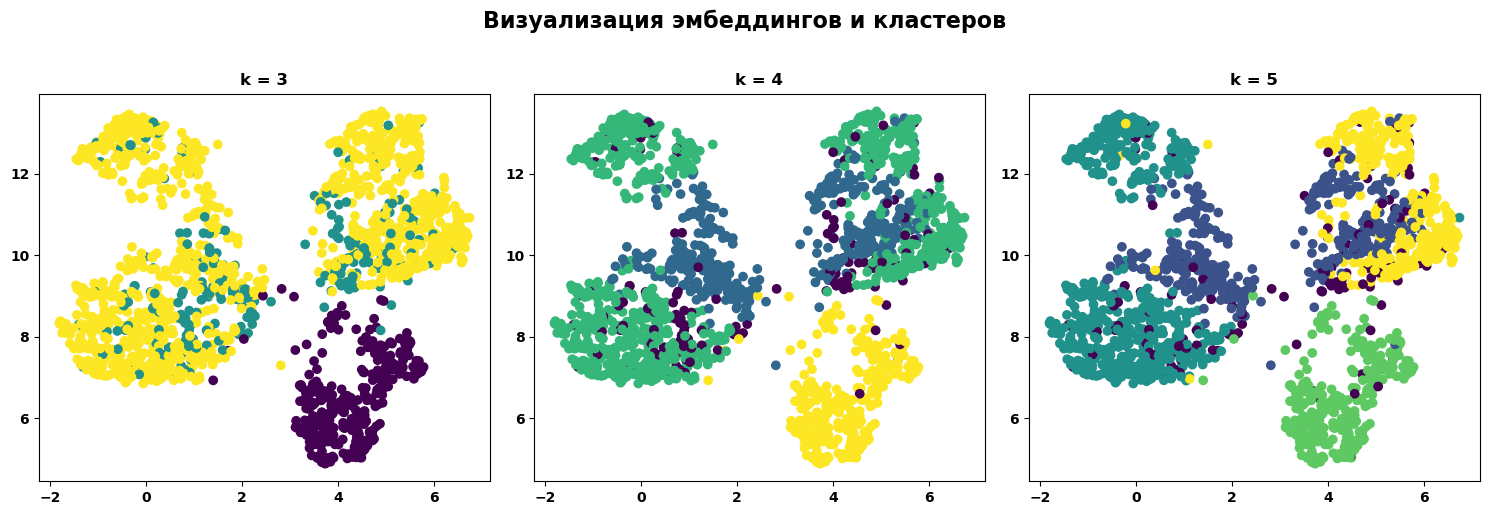

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, k in enumerate([3, 4, 5]):
    gmm = GaussianMixture(n_components=k, random_state=RAND)
    labels = gmm.fit_predict(df_cleaned)

    ax = axes[i]  
    ax.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

In [182]:
param_grid_gmm = {
    'n_components': [1, 2, 3],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
#     'tol': 0.001,
    'tol': np.linspace(0.01, 0.1, 3),
    'init_params': ['kmeans', 'random'],
    'random_state': [RAND]
}

clf_gmm = GaussianMixture()
grid_cv = GridSearchCV(clf_gmm,
                       param_grid_gmm,
                       scoring=make_scorer(silhouette_score),
                       verbose=1)

In [183]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 5.92 s


GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'init_params': ['kmeans', 'random'],
                         'n_components': [1, 2, 3], 'random_state': [10],
                         'tol': array([0.01 , 0.055, 0.1  ])},
             scoring=make_scorer(silhouette_score), verbose=1)

In [184]:
grid_cv.best_params_

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'n_components': 1,
 'random_state': 10,
 'tol': 0.01}

In [185]:
gmm = GaussianMixture(n_components=1, covariance_type='full',
                      init_params='kmeans', tol=0.01, random_state=RAND)
labels_gmm = gmm.fit_predict(df_cleaned)

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 5')

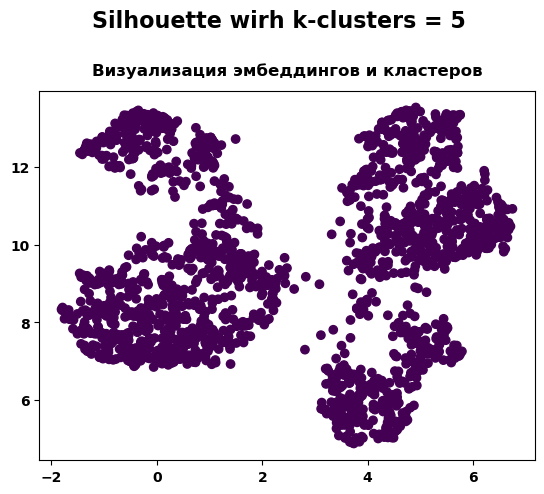

In [186]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_gmm)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {5}',
             fontsize=16,
             y=1.05)

In [192]:
param_grid_gmm = {
    'n_components': [1, 2, 3, 4, 5],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': np.linspace(0.001, 0.1, 3),
    'init_params': ['kmeans', 'random'],
    'random_state': [RAND]
}

clf_gmm = GaussianMixture()
grid_cv = GridSearchCV(clf_gmm,
                       param_grid_gmm,
                       scoring=make_scorer(silhouette_score),
                       verbose=1)

In [193]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Wall time: 11.5 s


GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'init_params': ['kmeans', 'random'],
                         'n_components': [1, 2, 3, 4, 5], 'random_state': [10],
                         'tol': array([0.001 , 0.0505, 0.1   ])},
             scoring=make_scorer(silhouette_score), verbose=1)

In [194]:
grid_cv.best_params_

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'n_components': 1,
 'random_state': 10,
 'tol': 0.001}

In [197]:
param_grid_gmm = {
    'n_components': [3, 4, 5, 6],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': np.linspace(0.001, 0.1, 3),
    'init_params': ['kmeans', 'random'],
    'max_iter': [100, 200],
    'random_state': [RAND]
}

clf_gmm = GaussianMixture()
grid_cv = GridSearchCV(clf_gmm,
                       param_grid_gmm,
                       scoring=make_scorer(silhouette_score),
                       verbose=1)

In [198]:
%%time
# производим обучение по сетке
grid_cv.fit(df_cleaned)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Wall time: 21.1 s


GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'init_params': ['kmeans', 'random'],
                         'max_iter': [100, 200], 'n_components': [3, 4, 5, 6],
                         'random_state': [10],
                         'tol': array([0.001 , 0.0505, 0.1   ])},
             scoring=make_scorer(silhouette_score), verbose=1)

In [199]:
grid_cv.best_params_ 

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'n_components': 3,
 'random_state': 10,
 'tol': 0.001}

In [25]:
gmm = GaussianMixture(n_components=3, covariance_type='full',
                      init_params='kmeans', tol=0.001, random_state=RAND)
labels_gmm = gmm.fit_predict(df_cleaned)

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 5')

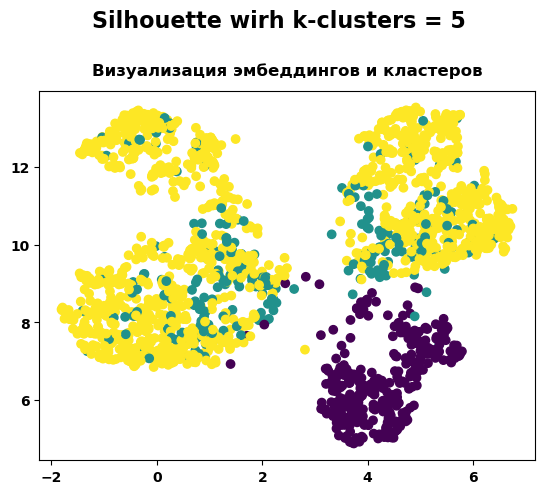

In [26]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_gmm)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {5}',
             fontsize=16,
             y=1.05)

In [ ]:
gmm = GaussianMixture(n_components=5, covariance_type='full',
                      init_params='kmeans', tol=0.001, random_state=RAND)
labels_gmm = gmm.fit_predict(df_cleaned)

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 5')

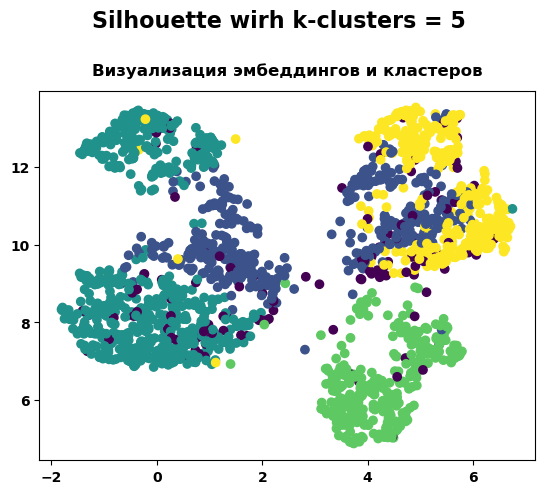

In [204]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_gmm)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {5}',
             fontsize=16,
             y=1.05)

В нашем случае заданное кол-во смесей совпадает с кол-вом кластеров, которые находит GMM.

## Voting

Тк к алгоритмам кластеризации не применяется стекинг и блэндинг, используем метод голосования, чтобы объединить результаты:

In [210]:
from scipy.stats import mode

In [238]:
kmeans = KMeans(n_clusters=5, random_state=RAND, init='random', max_iter=100)
agglomerative = AgglomerativeClustering(n_clusters=5,
                                         affinity='euclidean',
                                         linkage='ward')
spectral = SpectralClustering(n_clusters=5,
                                  affinity='nearest_neighbors',
                                  gamma=0.1,
                                  random_state=RAND)

In [239]:
kmeans_labels = kmeans.fit_predict(df_cleaned)
agglomerative_labels = agglomerative.fit_predict(df_cleaned)
spectral_labels = spectral.fit_predict(df_cleaned)

In [240]:
labels = np.array([kmeans_labels, agglomerative_labels, spectral_labels])
final_labels = mode(labels)[0][0]

In [241]:
final_labels

array([1, 1, 0, ..., 2, 1, 4], dtype=int64)

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

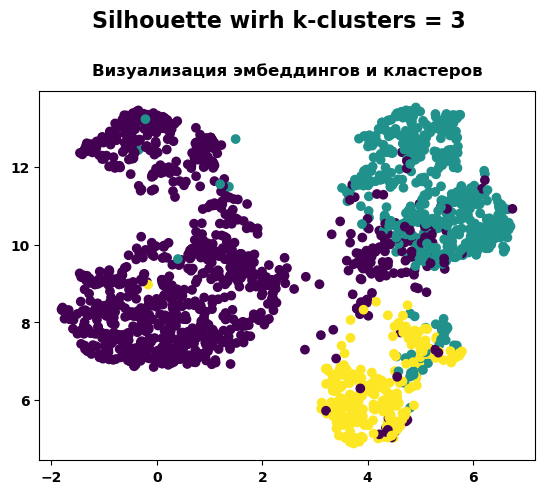

In [237]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=final_labels)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}',
             fontsize=16,
             y=1.05)

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 4')

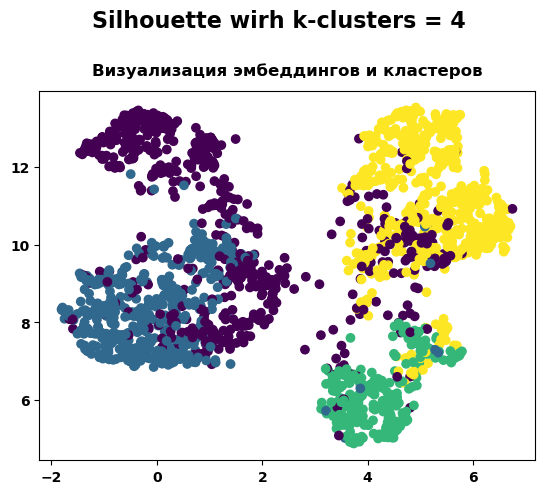

In [223]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=final_labels)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {4}',
             fontsize=16,
             y=1.05)

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 5')

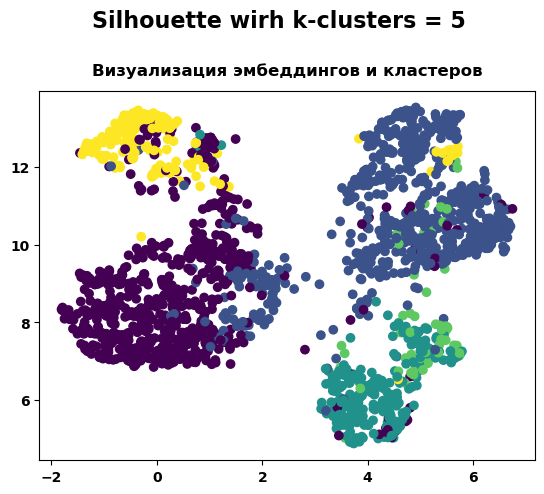

In [242]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=final_labels)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {5}',
             fontsize=16,
             y=1.05)